<h1><center>CSCI - 4146 - The Process of Data Science - Fall 2020</h1></center>
<h1><center>Assignment 1</h1></center>

<b>Katherine Lin</b>  
B00735778


<b>Lingyu Ye</b>  
B00724509

In [1]:
import zipfile
with zipfile.ZipFile('boston.zip', 'r') as myzip:
    myzip.extractall("./data")

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import seaborn as sns # for correlation heatmap
import xgboost as xgb

In [3]:
# Note: Naming convention for DataFrame variables is appending _df to a variable name
listings_df = pd.read_csv('data/boston/listings.csv')
listings_df.head(1)

id  ... reviews_per_month
0  12147973  ...               NaN

[1 rows x 95 columns]

In [4]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

**Comment:** We can see  here that features like 'security_deposite' are labeled as categorical features (objects) because of the dollar sign that is attached to it. For the 'host_response_rate' & 'host_acceptance_rate', the % sign attached made the features categorical. We would like to transform them into continuous features first.

In [5]:
# replace the NaN values in 'host_response_rate' & 'host_acceptance_rate' with 0
listings_df.host_response_rate = listings_df['host_response_rate'].fillna(0);
listings_df.host_acceptance_rate = listings_df['host_acceptance_rate'].fillna(0);
# remove the % sign in 'host_response_rate' & 'host_acceptance_rate'
# listings_df.info()
listings_df['host_response_rate'] = (listings_df['host_response_rate'].str[:-1].astype(float))
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str[:-1].astype(float)

In [6]:
# replace the NaN values in 'price', 'security_deposit', 'cleaning_fee', 'extra_people'
listings_df['price']  = listings_df['price'].fillna(0);
listings_df['security_deposit']  = listings_df['security_deposit'].fillna(0);
listings_df['cleaning_fee']  = listings_df['cleaning_fee'].fillna(0);
listings_df['extra_people']  = listings_df['extra_people'].fillna(0);

# remove the $ sign and commas in 'price', 'security_deposit', 'cleaning_fee', 'extra_people'
listings_df['price'] = (listings_df['price'].str.replace(',', '').str[1:].astype(float))
listings_df['security_deposit'] = (listings_df['security_deposit'].str.replace(',', '').str[1:].astype(float))
listings_df['cleaning_fee'] = (listings_df['cleaning_fee'].str.replace(',', '').str[1:].astype(float))
listings_df['extra_people'] = (listings_df['extra_people'].str.replace(',', '').str[1:].astype(float))

In [7]:
listings_df.isna().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   756
Length: 95, dtype: int64

We can see there are some columns where majority of the entries are null, we can add them to the drop list

In [8]:
#dropping obvious useless columns (urls, null columns (or too much missing values), wordy descriptions, repetitive column)
listings_1st_clean = listings_df.drop(['listing_url','scrape_id','last_scraped','name', 'square_feet',
                                       'summary','description','space','neighborhood_overview',
                                      'notes','thumbnail_url','medium_url','xl_picture_url',
                                       'transit','experiences_offered','access','interaction',
                                       'house_rules','picture_url', 'host_total_listings_count',
                                       'host_acceptance_rate','host_verifications','host_id',
                                       'host_url','host_name','host_since','host_location',
                                       'host_about','host_thumbnail_url','host_picture_url', 
                                       'weekly_price', 'host_response_time',
                                       'monthly_price','host_neighbourhood','neighbourhood_group_cleansed',
                                       'neighbourhood','smart_location','country_code','state', 
                                       'street', 'country','calendar_updated',
                                       'has_availability','calendar_last_scraped', 'first_review', 'last_review',
                                       'reviews_per_month','amenities',
                                       'license','jurisdiction_names', 'require_guest_profile_picture', 
                                       'require_guest_phone_verification'], axis = 1)

Now we can build reports for continuous and categorical features to further investigate on data quality and further determine which features are absolutely neccessary and needs work

In [9]:
def buildContinuousFeaturesReport(features, data_df):
	conHead = ['Count', 'Miss %', 'Card.', 'Min', '1st Qrt.',
            'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']

	conOut_df = pd.DataFrame(index=features, columns=conHead)
	columns_df = data_df[features]

	#COUNT
	conOut_df[conHead[0]] = len(columns_df)

	#MISS % 
	conOut_df[conHead[1]] = columns_df.isna().sum() / len(columns_df) * 100

	#CARDINALITY
	conOut_df[conHead[2]] = columns_df.nunique()

	#MINIMUM
	conOut_df[conHead[3]] = columns_df.min()

	#1ST QUARTILE
	conOut_df[conHead[4]] = columns_df.quantile(0.25)

	#MEAN
	conOut_df[conHead[5]] = columns_df.mean()

	#MEDIAN
	conOut_df[conHead[6]] = columns_df.median()

	#3rd QUARTILE
	conOut_df[conHead[7]] = columns_df.quantile(0.75)

	#MAX
	conOut_df[conHead[8]] = columns_df.max()

	#STANDARD DEVIATION
	conOut_df[conHead[9]] = columns_df.std()

	return conOut_df

In [10]:
with pd.option_context('display.float_format', '{:.2f}'.format):
  display(buildContinuousFeaturesReport(listings_1st_clean.select_dtypes('number').columns.to_list(), listings_1st_clean))

Count  Miss %  ...         Max  Std. Dev.
id                               3585    0.00  ... 14933461.00 4500786.86
host_response_rate               3585   13.14  ...      100.00      12.52
host_listings_count              3585    0.00  ...      749.00     171.12
latitude                         3585    0.00  ...       42.39       0.02
longitude                        3585    0.00  ...      -71.00       0.03
accommodates                     3585    0.00  ...       16.00       1.78
bathrooms                        3585    0.39  ...        6.00       0.50
bedrooms                         3585    0.28  ...        5.00       0.75
beds                             3585    0.25  ...       16.00       1.01
price                            3585    0.00  ...     4000.00     148.33
security_deposit                 3585   62.57  ...     4500.00     328.87
cleaning_fee                     3585   30.88  ...      300.00      51.30
guests_included                  3585    0.00  ...       14.00       1.06
extra_people                     3585    0.00  ...      200.00      19.14
minimum_nights                   3585    0.00  ...      300.00       8.87
maximum_nights                   3585    0.00  ... 99999999.00 1670135.94
availability_30                  3585    0.00  ...       30.00      10.44
availability_60                  3585    0.00  ...       60.00      21.86
availability_90                  3585    0.00  ...       90.00      33.16
availability_365                 3585    0.00  ...      365.00     142.14
number_of_reviews                3585    0.00  ...      404.00      35.57
review_scores_rating             3585   22.68  ...      100.00       9.53
review_scores_accuracy           3585   22.96  ...       10.00       0.93
review_scores_cleanliness        3585   22.82  ...       10.00       1.17
review_scores_checkin            3585   22.87  ...       10.00       0.76
review_scores_communication      3585   22.82  ...       10.00       0.74
review_scores_location           3585   22.93  ...       10.00       0.90
review_scores_value              3585   22.90  ...       10.00       1.01
calculated_host_listings_count   3585    0.00  ...      136.00      29.42

[29 rows x 10 columns]

In [11]:
# only keep 1 availabiliy feature, 365 days shows all year trend, we thought it is more useful.
listings_1st_clean.drop(['availability_30', 'availability_60', 'availability_90'], axis=1, inplace=True)

In [12]:
# replace the missing values using median values to better generalize and avoid fraction (mean)
for col in ['bathrooms', 'bedrooms', 'beds','review_scores_location',
            'review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value' ]:
    listings_1st_clean[col].fillna(listings_1st_clean[col].median(), inplace=True)

# replace the missing values using mean values to have a average representation
for col in ['security_deposit', 'cleaning_fee' ]:
    listings_1st_clean[col].fillna(listings_1st_clean[col].mean(), inplace=True)    


In [13]:
#categorize host response rate to account for missing values
# Bin into four categories
listings_1st_clean.host_response_rate = pd.cut(listings_1st_clean.host_response_rate, bins=[0, 50, 80, 99, 100], labels=['0-49%', '50-79%', '90-99%', '100%'], include_lowest=True)

# Converting to string
listings_1st_clean.host_response_rate = listings_1st_clean.host_response_rate.astype('str')

# Replace nulls with 'unknown'
listings_1st_clean.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings_1st_clean.host_response_rate.value_counts()

100%       2072
90-99%      736
unknown     471
50-79%      242
0-49%        64
Name: host_response_rate, dtype: int64

#### Continuous Features Plots

In [14]:
# Histograms
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [100, 60]
plt.rcParams["font.size"] = 50
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

listings_1st_clean.select_dtypes('number').hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1390f324a8>,
      dtype=object)

**Comment** Here we can see that the review score features are skewed left. Security deposit, guest included, extra people feature have the same distribution as price. They are most likely very correlated.

In [15]:
# Replot price histogram with better bin slicing
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplots_adjust(bottom=-0.5)

plt.subplot(2,2,1)
plt.xlim(0,1500)
plt.title('price')
listings_1st_clean['price'].hist(bins = 100);

#replot security_deposit histogram with better bin slicing
plt.subplot(2,2,2)
plt.title('security_deposit')
listings_1st_clean['security_deposit'].plot(kind = 'hist', bins = 10, color='#4A0B61')

#replot cleaning_fee histogram with better bin slicing
plt.subplot(2,2,3)
plt.xlim(0, 400)
plt.title('cleaning_fee')
listings_1st_clean['cleaning_fee'].plot(kind = 'hist', bins = 10, color='#FFCF56')


In [16]:
print(f"Nightly advertised prices range from ${min(listings_1st_clean.price)} to ${max(listings_1st_clean.price)}.")

Nightly advertised prices range from $10.0 to $4000.0.


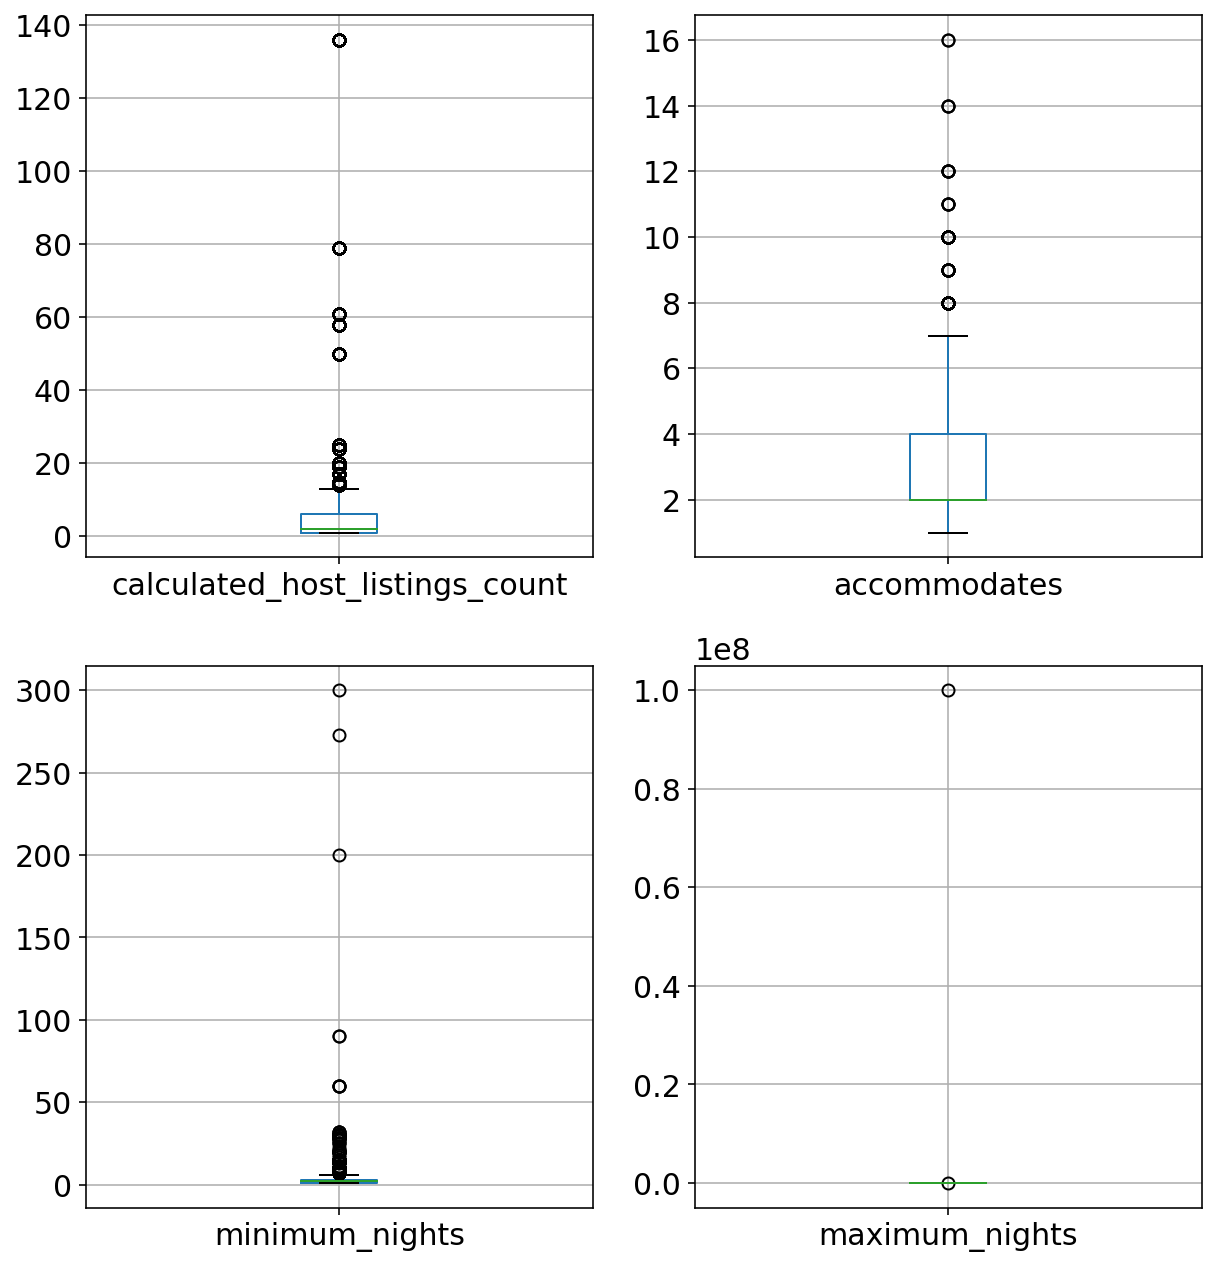

In [17]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 15

plt.subplots_adjust(bottom=-0.5)

plt.subplot(2,2,1)
listings_1st_clean.boxplot(column=['calculated_host_listings_count']);

plt.subplot(2,2,2)
listings_1st_clean.boxplot(column=['accommodates']);

plt.subplot(2,2,3)
listings_1st_clean.boxplot(column=['minimum_nights']);

plt.subplot(2,2,4)
listings_1st_clean.boxplot(column=['maximum_nights']);

**Comment:**
We can have a closer look from the box plot that these cont. features, specially maximum_nights have outlier problems that needs to be delt with.

In [18]:
def buildCategoricalFeaturesReport(features, data_df):
	catHead = ['Count', 'Miss %', 'Card.', 'Mode', 'Mode Freq',
            'Mode %', '2nd Mode', '2nd Mode Freq', '2nd Mode %']

	columns_df = data_df[features]

	#preparing a dictionary for storing data
	stats_dict = {k: ['']*len(features) for k in catHead}

	#CARDINALITY
	stats_dict['Card.'] = columns_df.nunique()

	missing = columns_df.isna().sum() / len(columns_df) * 100

	for col in columns_df:
		values = columns_df[col].value_counts()
		index = features.index(col)

    #COUNT
		stats_dict['Count'][index] = len(columns_df)
		
		#MISS %
		stats_dict['Miss %'][index] = missing[col]

		#MODES
		mode = values.index[0]
		mode2 = values.index[1] if len(values.index) > 1 else mode
		stats_dict['Mode'][index] = mode
		stats_dict['2nd Mode'][index] = mode2

		#MODE FREQ
		modeCount = values.loc[mode]
		modeCount2 = values.loc[mode2]
		stats_dict['Mode Freq'][index] = modeCount
		stats_dict['2nd Mode Freq'][index] = modeCount2

		#MODE %
		miss = stats_dict['Miss %'][index]

		modePer = (modeCount/(len(columns_df)*((100-miss)/100)))*100
		stats_dict['Mode %'][index] = round(modePer, 2)

		modePer2 = (modeCount2/(len(columns_df)*((100-miss)/100)))*100
		stats_dict['2nd Mode %'][index] = round(modePer2, 2)
	
	output_df = pd.DataFrame.from_dict(stats_dict)
	return output_df

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None), pd.option_context('display.float_format', '{:.2f}'.format):
  display(buildCategoricalFeaturesReport(listings_1st_clean.select_dtypes(include='object').columns.to_list(), listings_1st_clean))

Count  Miss %  Card.             Mode  Mode Freq  \
host_response_rate       3585    0.00      5             100%       2072   
host_is_superhost        3585    0.00      2                f       3178   
host_has_profile_pic     3585    0.00      2                t       3577   
host_identity_verified   3585    0.00      2                t       2603   
neighbourhood_cleansed   3585    0.00     25    Jamaica Plain        343   
city                     3585    0.06     38           Boston       3381   
zipcode                  3585    1.06     43            02116        388   
market                   3585    0.39      4           Boston       3568   
is_location_exact        3585    0.00      2                t       3080   
property_type            3585    0.08     13        Apartment       2612   
room_type                3585    0.00      3  Entire home/apt       2127   
bed_type                 3585    0.00      5         Real Bed       3453   
requires_license         3585    0.00      1                f       3585   
instant_bookable         3585    0.00      2                f       2991   
cancellation_policy      3585    0.00      4           strict       1582   

                        Mode %          2nd Mode  2nd Mode Freq  2nd Mode %  
host_response_rate       57.80            90-99%            736       20.53  
host_is_superhost        88.65                 t            407       11.35  
host_has_profile_pic     99.78                 f              8        0.22  
host_identity_verified   72.61                 f            982       27.39  
neighbourhood_cleansed    9.57         South End            326        9.09  
city                     94.36  Roxbury Crossing             24        0.67  
zipcode                  10.94             02130            331        9.33  
market                   99.92     San Francisco              1        0.03  
is_location_exact        85.91                 f            505       14.09  
property_type            72.92             House            562       15.69  
room_type                59.33      Private room           1378       38.44  
bed_type                 96.32             Futon             51        1.42  
requires_license        100.00                 f           3585      100.00  
instant_bookable         83.43                 t            594       16.57  
cancellation_policy      44.13          flexible            999       27.87

In [20]:
# Replacing columns with binary value t/f with 0/1
listings_1st_clean.replace({'f': 0, 't': 1}, inplace=True)

**Comment**: Here, we look at the property types and the distribution is heavily lean towords apartment, some of the types only has one listing. Therefore we try grouping them to reduce the dimension of features for more effecient computing

In [21]:
listings_1st_clean.property_type.value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

In [22]:
# Clean up property_type to 3 categories, Apartment, House & Other
listings_1st_clean.property_type.replace({
    'Townhouse': 'House',
    'Loft': 'Apartment',
    'Condominium': 'Apartment',
    'Villa': 'House',
    'Entire Floor': 'Apartment',
    'Dorm': 'Apartment',
    'Guesthouse': 'House'  
    }, inplace=True)

listings_1st_clean.loc[~listings_1st_clean.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
# listings_1st_clean.property_type.value_counts()

#### Categorical Features Plots

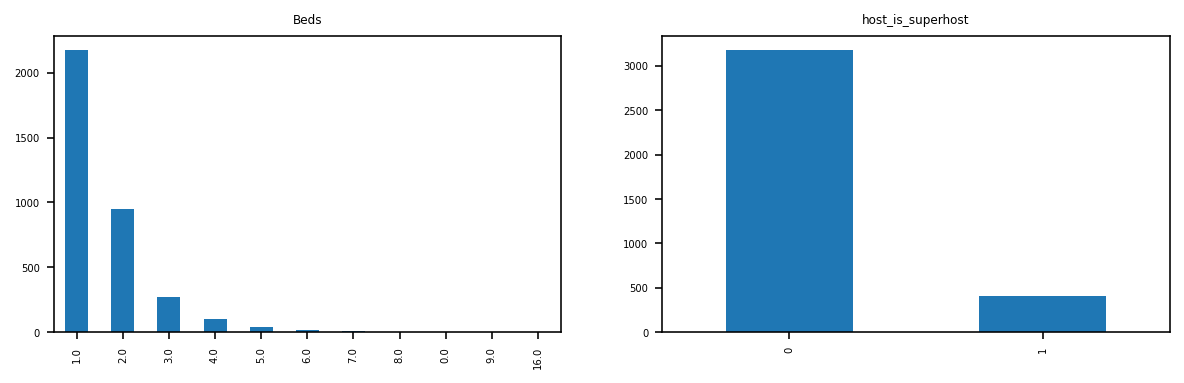

In [23]:
#box plots

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 5

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(2,2,1)
plt.title('Beds')
listings_1st_clean['beds'].value_counts().plot.bar();

plt.subplot(2,2,2)
plt.title('host_is_superhost')
listings_1st_clean['host_is_superhost'].value_counts().plot.bar();

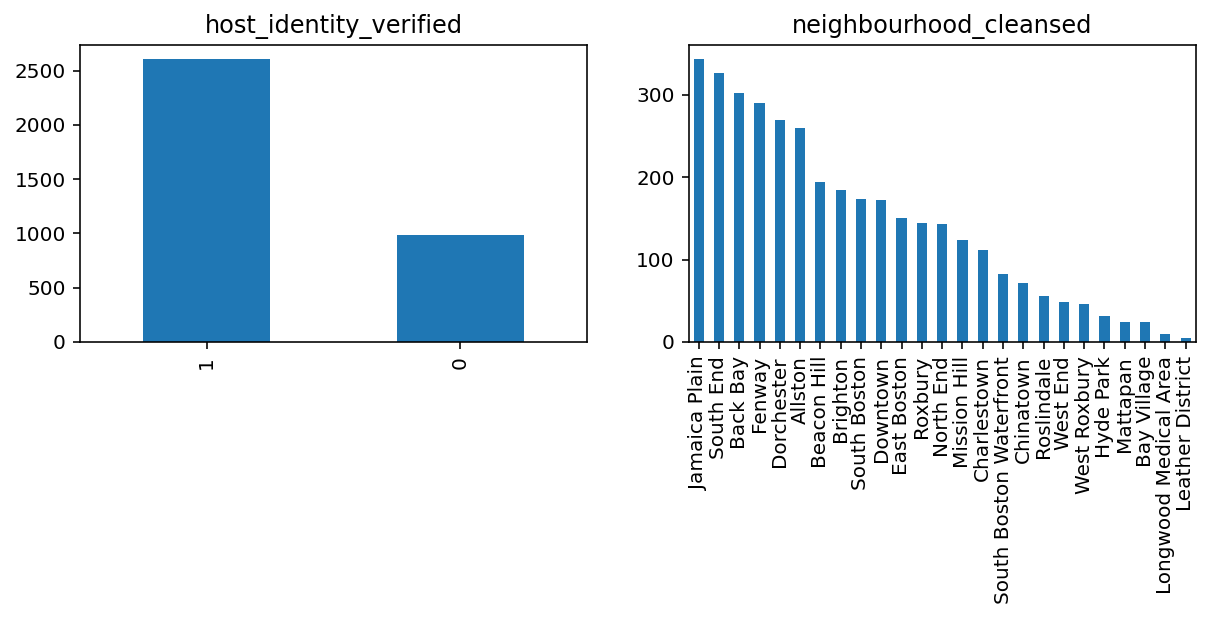

In [24]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 10

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(2,2,1)
plt.title('host_identity_verified')
listings_1st_clean['host_identity_verified'].value_counts().plot.bar();

plt.subplot(2,2,2)
plt.title('neighbourhood_cleansed')
listings_1st_clean['neighbourhood_cleansed'].value_counts().plot.bar();

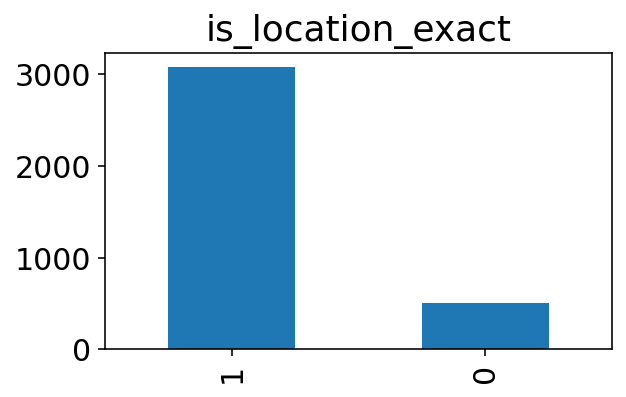

In [25]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 15

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplot(2,2,1)
plt.title('is_location_exact')
listings_1st_clean['is_location_exact'].value_counts().plot.bar();

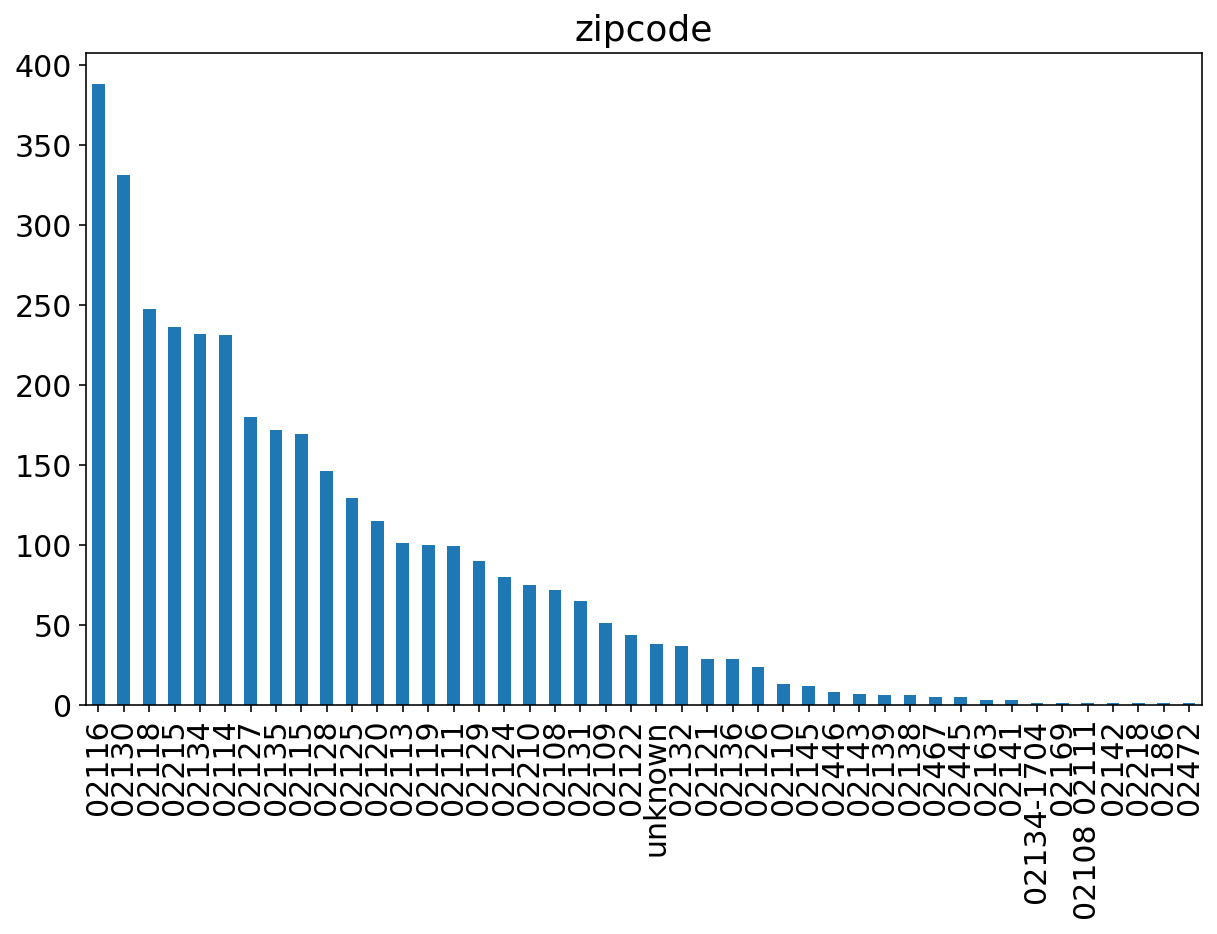

In [26]:
%config InlineBackend.figure_format = 'retina'
listings_1st_clean['zipcode'] = listings_1st_clean['zipcode'].fillna('unknown')

plt.title('zipcode')
listings_1st_clean['zipcode'].value_counts().plot.bar();

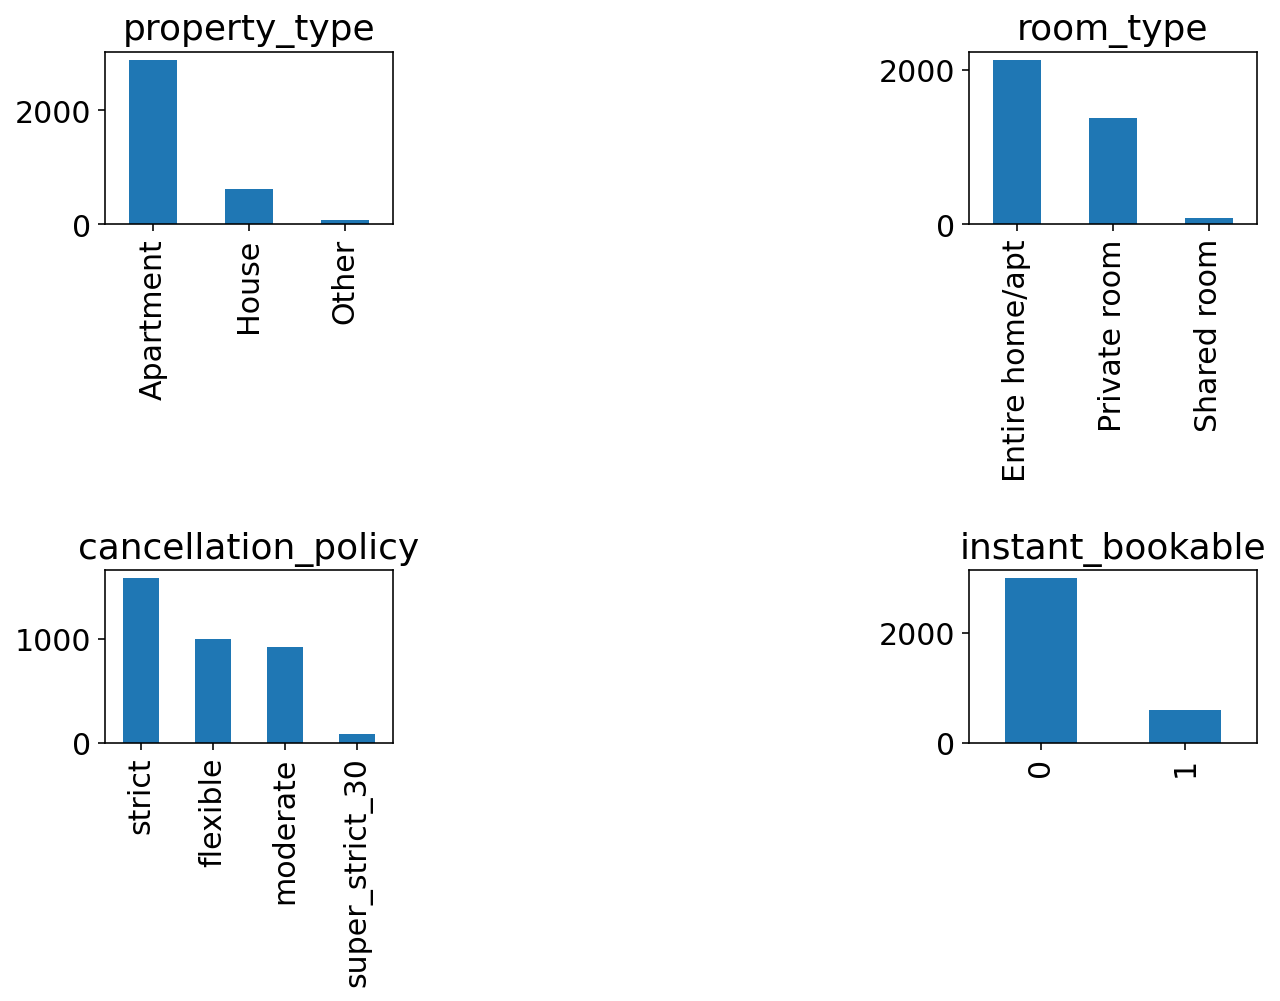

In [27]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 15

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=2, hspace=2)

plt.subplot(2,2,1)
plt.title('property_type')
listings_1st_clean['property_type'].value_counts().plot.bar();

plt.subplot(2,2,2)
plt.title('room_type')
listings_1st_clean['room_type'].value_counts().plot.bar();

plt.subplot(2,2,3)
plt.title('cancellation_policy')
listings_1st_clean['cancellation_policy'].value_counts().plot.bar();

plt.subplot(2,2,4)
plt.title('instant_bookable')
listings_1st_clean['instant_bookable'].value_counts().plot.bar();

In [28]:
# amenities vs price plots
# reference https://github.com/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    listings_1st_clean.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    listings_1st_clean.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price ($)')
    ax2.set_xlabel('')
    
    plt.show()
    
for col in listings_1st_clean.iloc[:,40:-1].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

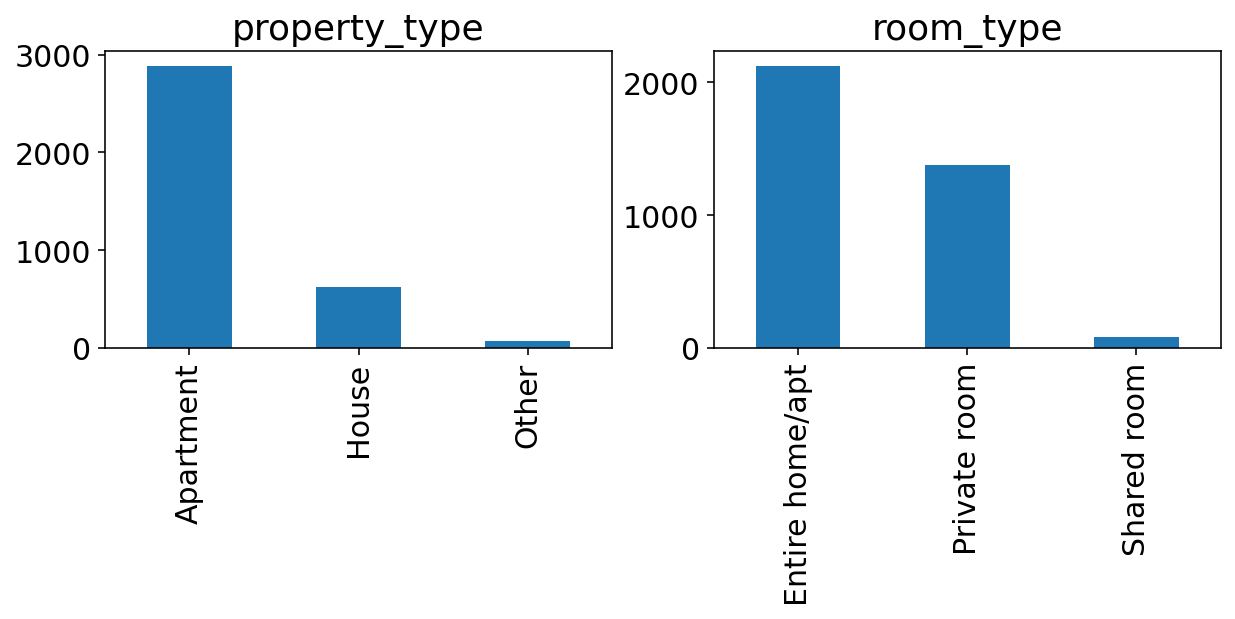

In [29]:
plt.subplot(2,2,1)
plt.title('property_type')
listings_1st_clean['property_type'].value_counts().plot.bar();

plt.subplot(2,2,2)
plt.title('room_type')
listings_1st_clean['room_type'].value_counts().plot.bar();

**Comment:** We can see from these bar plots that market, host_has_profile_pic, require_license, city & bed_type feature only dominant with 1 value and it would not be useful for the prediction, therefore, we could drop them. 

Maximum night has a huge outlier and it is hard to represent in the features in terms of infinity days stay, therefore we could just drop it.

All the categorical features will be transformed with OneHot Encoding later.

In [30]:
listings_1st_clean = listings_1st_clean.drop(['market', 'requires_license', 'city', 'bed_type', 'host_has_profile_pic', 'host_listings_count', 'zipcode', 'maximum_nights'], axis = 1)

### What is the neighbourhood with the highest average rating?

In [31]:
import numpy as np
# copy columns into a new dataframe insight
insights = listings_1st_clean[['neighbourhood_cleansed', 'review_scores_rating']].copy()

# pivot the dataframe and find the mean of prices
insights = pd.pivot_table(insights, values = 'review_scores_rating', index = 'neighbourhood_cleansed', aggfunc={'review_scores_rating': np.mean})
# insights.head(100)

# get the neighbourhood that has the max avg score
insights.loc[insights['review_scores_rating'].idxmax()]

review_scores_rating    96.6
Name: Leather District, dtype: float64

### What are the major characteristics of this neighbourhood (e.g., type of listing, host rating, etc)?
 We can look at price, minimum nights spent, cancellation_policy, property_type, room_type,  review_score_location

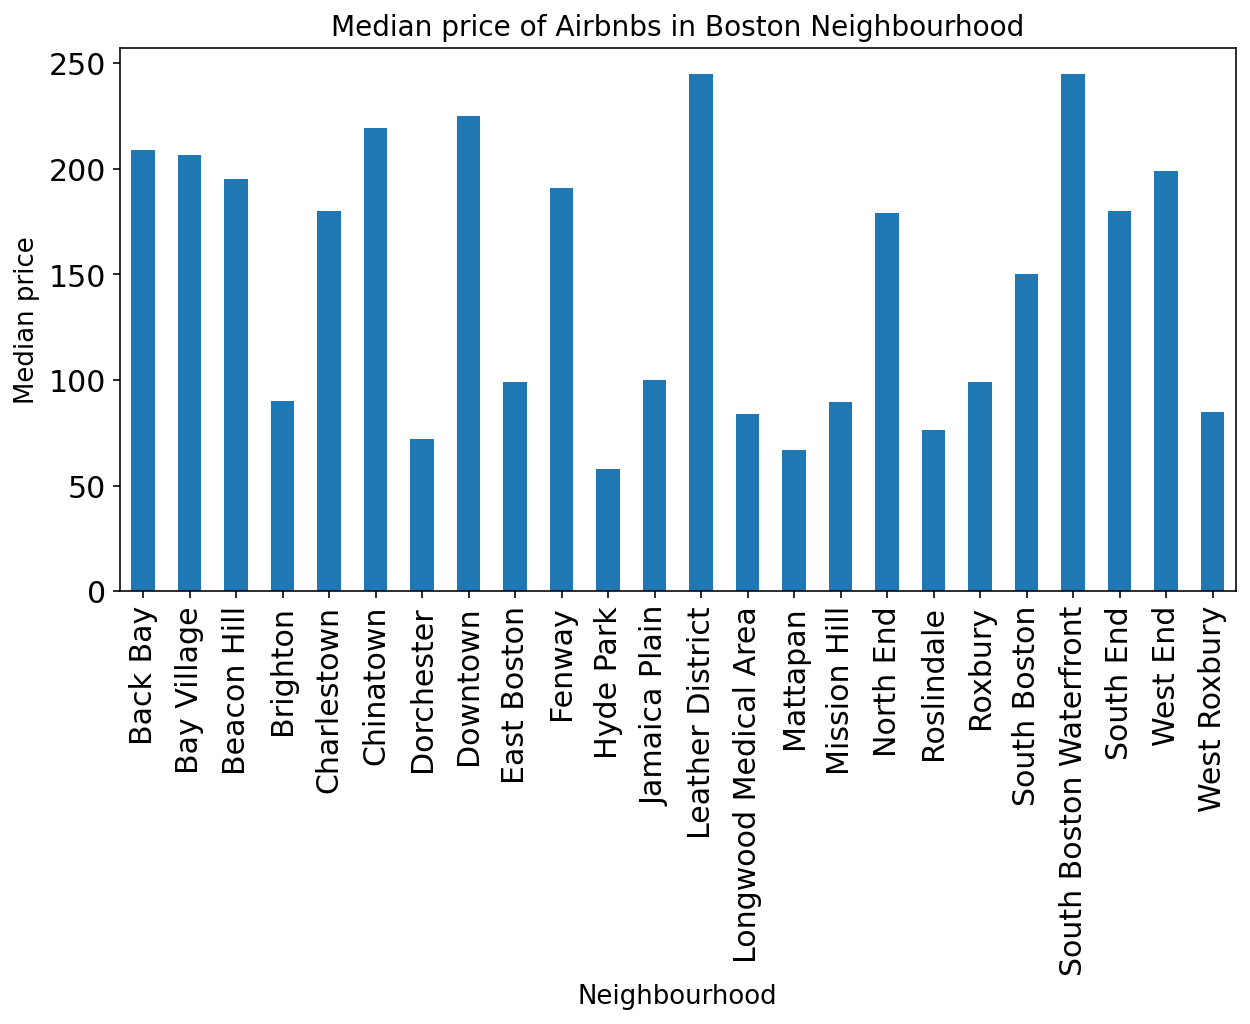

In [32]:
# price
plt.figure(figsize=(10,5))
listings_1st_clean.groupby(['neighbourhood_cleansed']).price.median().plot(kind='bar')
plt.title('Median price of Airbnbs in Boston Neighbourhood', fontsize=14)
plt.xlabel('Neighbourhood', fontsize=13)
plt.ylabel('Median price', fontsize=13)
plt.xticks(rotation=90)
plt.xlim(left=0.5)
plt.show()

**Comment:** From the plot, we can see that Leather District has one of the highest median price in Boston area. Having different access to amenities might be a reason why, therefore, we will plot a diagram for amenities access in Leather District

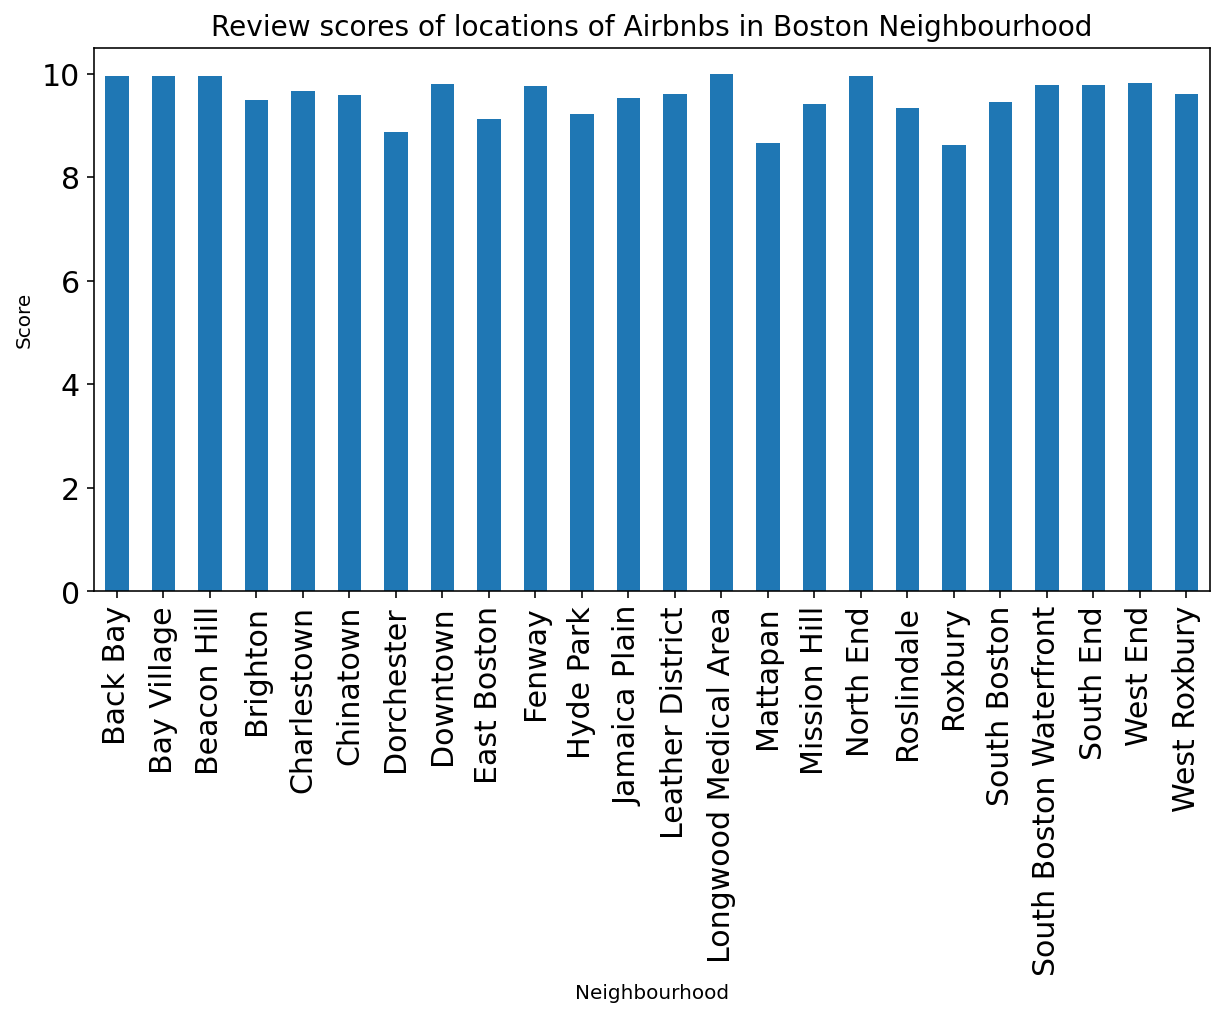

In [33]:
# review score location
plt.figure(figsize=(10,5))
listings_1st_clean.groupby(['neighbourhood_cleansed']).review_scores_location.mean().plot(kind='bar')
plt.title('Review scores of locations of Airbnbs in Boston Neighbourhood', fontsize=14)
plt.xlabel('Neighbourhood', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.xticks(rotation=90)
plt.xlim(left=0.5)
plt.show()

**Comment:** Leather District is one of the higher rated location in all locations listed.

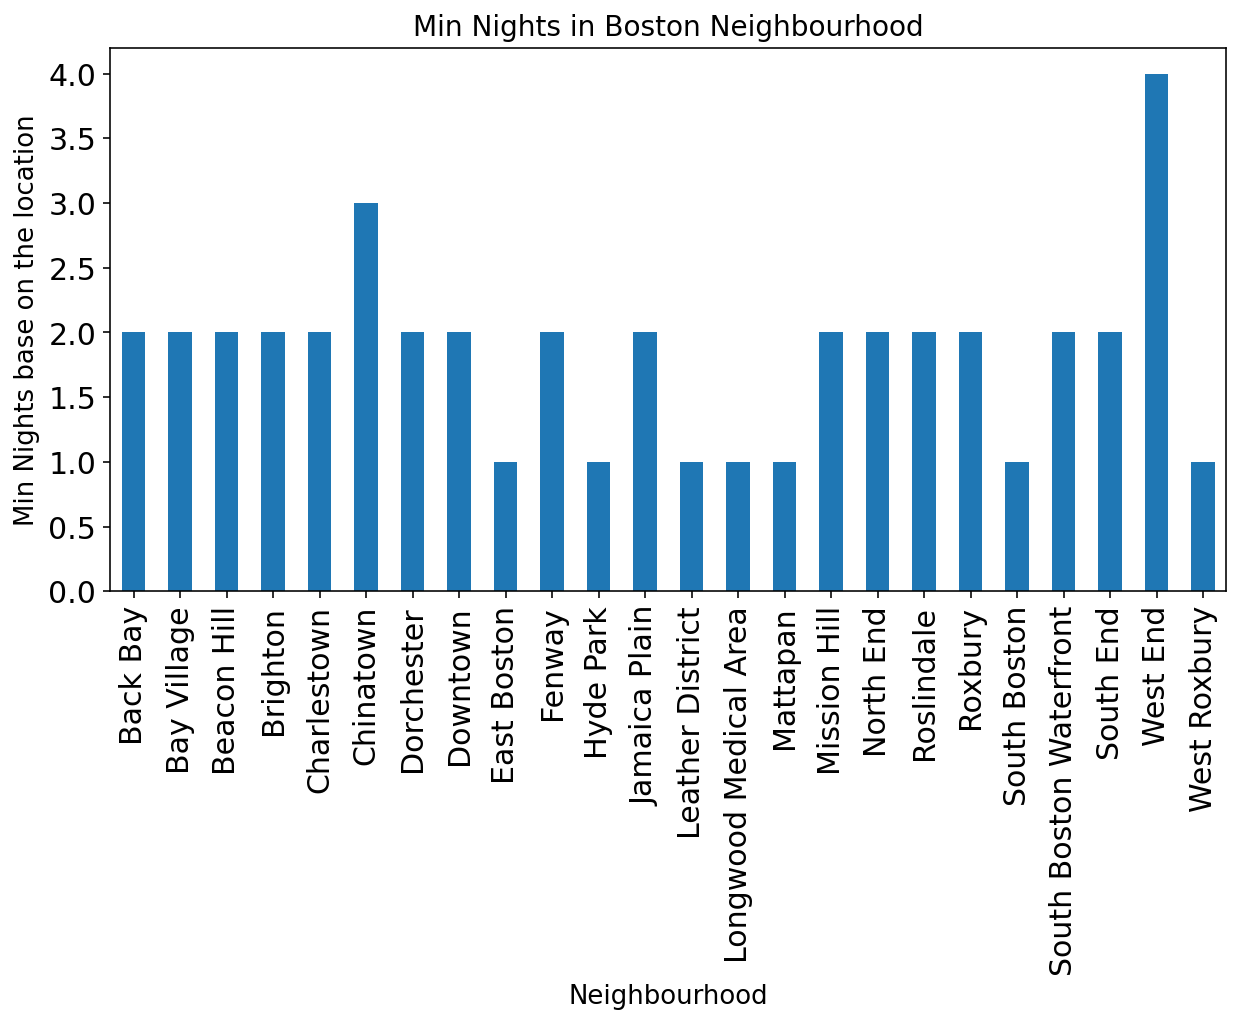

In [34]:
# min nights

plt.figure(figsize=(10,5))
listings_1st_clean.groupby(['neighbourhood_cleansed']).minimum_nights.median().plot(kind='bar')
plt.title('Min Nights in Boston Neighbourhood', fontsize=14)
plt.xlabel('Neighbourhood', fontsize=13)
plt.ylabel('Min Nights base on the location', fontsize=13)
plt.xticks(rotation=90)
plt.xlim(left=0.5)
plt.show()

**Comment:** The minimum nights a person can stay at a Airbnb in Leather District is 1 night, people are more open to stay at place with less minimum nights requirement because they can be very flexible with their schedule.

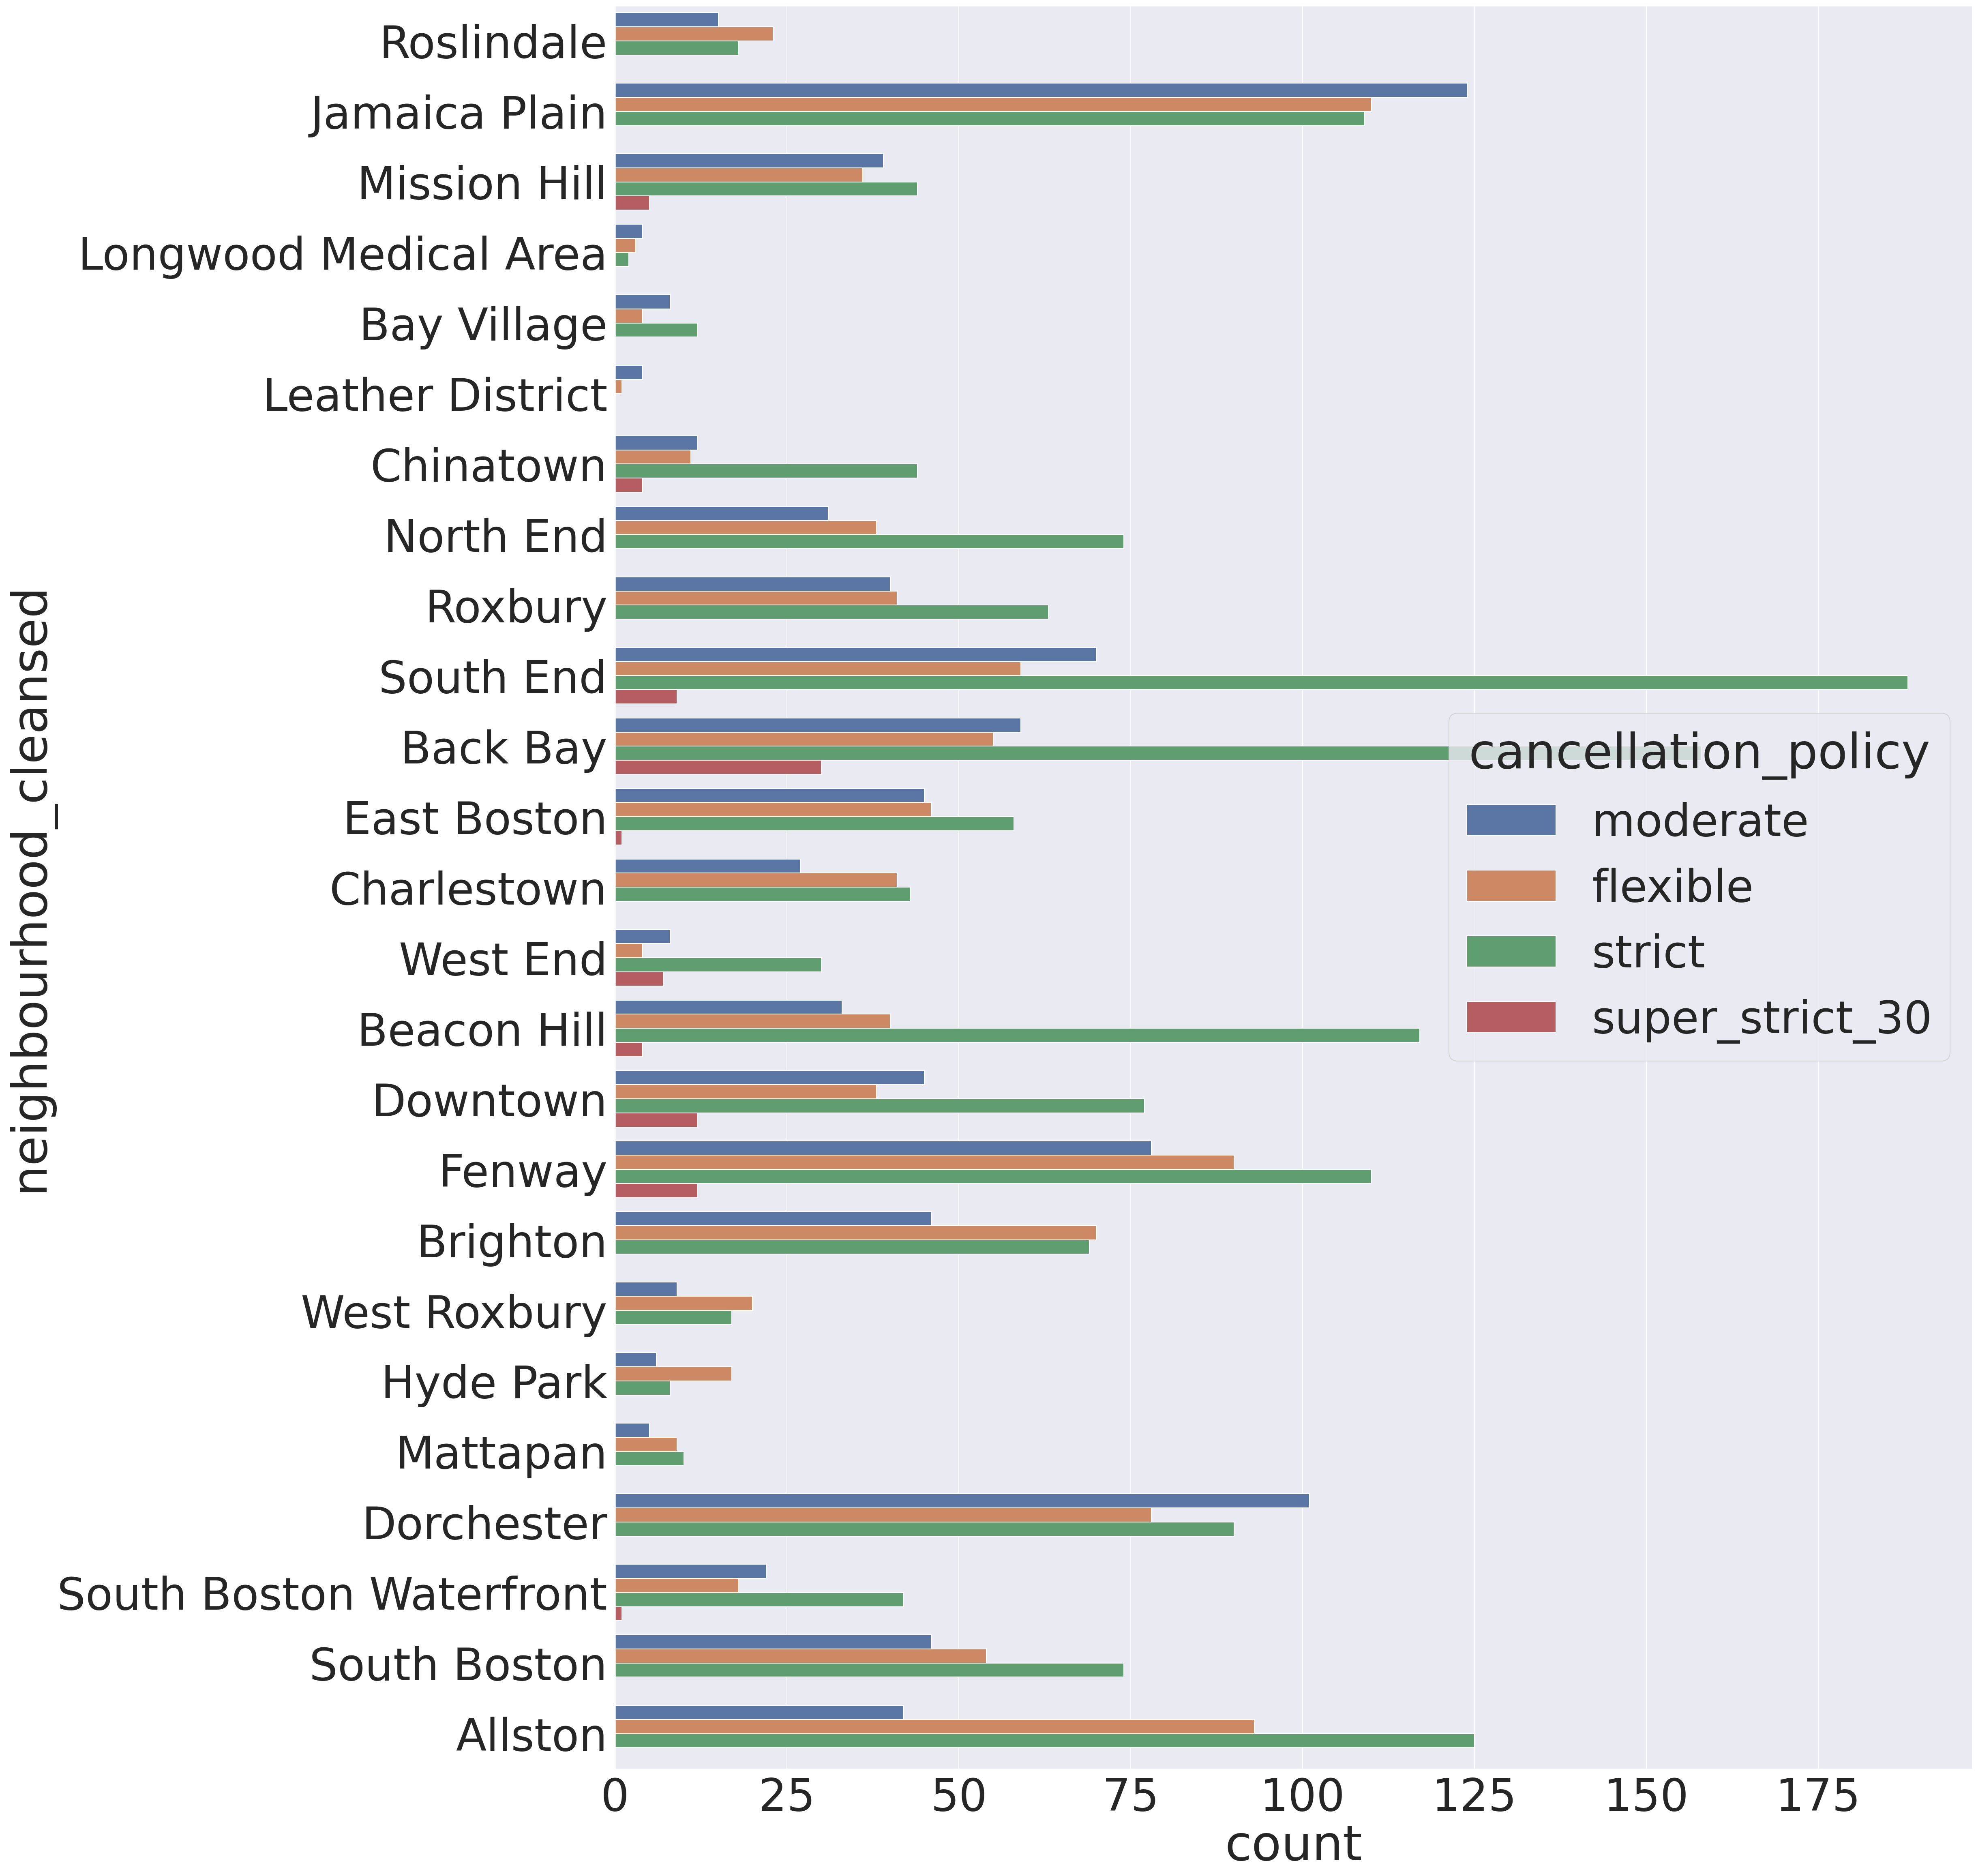

In [35]:
import seaborn as sns
fig = plt.gcf()

# Change seaborn plot size & font size
fig.set_size_inches(30, 40)

sns.set(font_scale=5)
# copy columns into a new dataframe 
cancellation_policy_df = listings_1st_clean[['neighbourhood_cleansed', 'cancellation_policy']].copy()

sns.countplot(y = "neighbourhood_cleansed", hue = "cancellation_policy", data=cancellation_policy_df)

**Comment:** This graph further demonstrated the flexibility of Leather District with flexible and moderate cancelation policy. There is no listing with strict and superstrict policies like some of the districts do. 

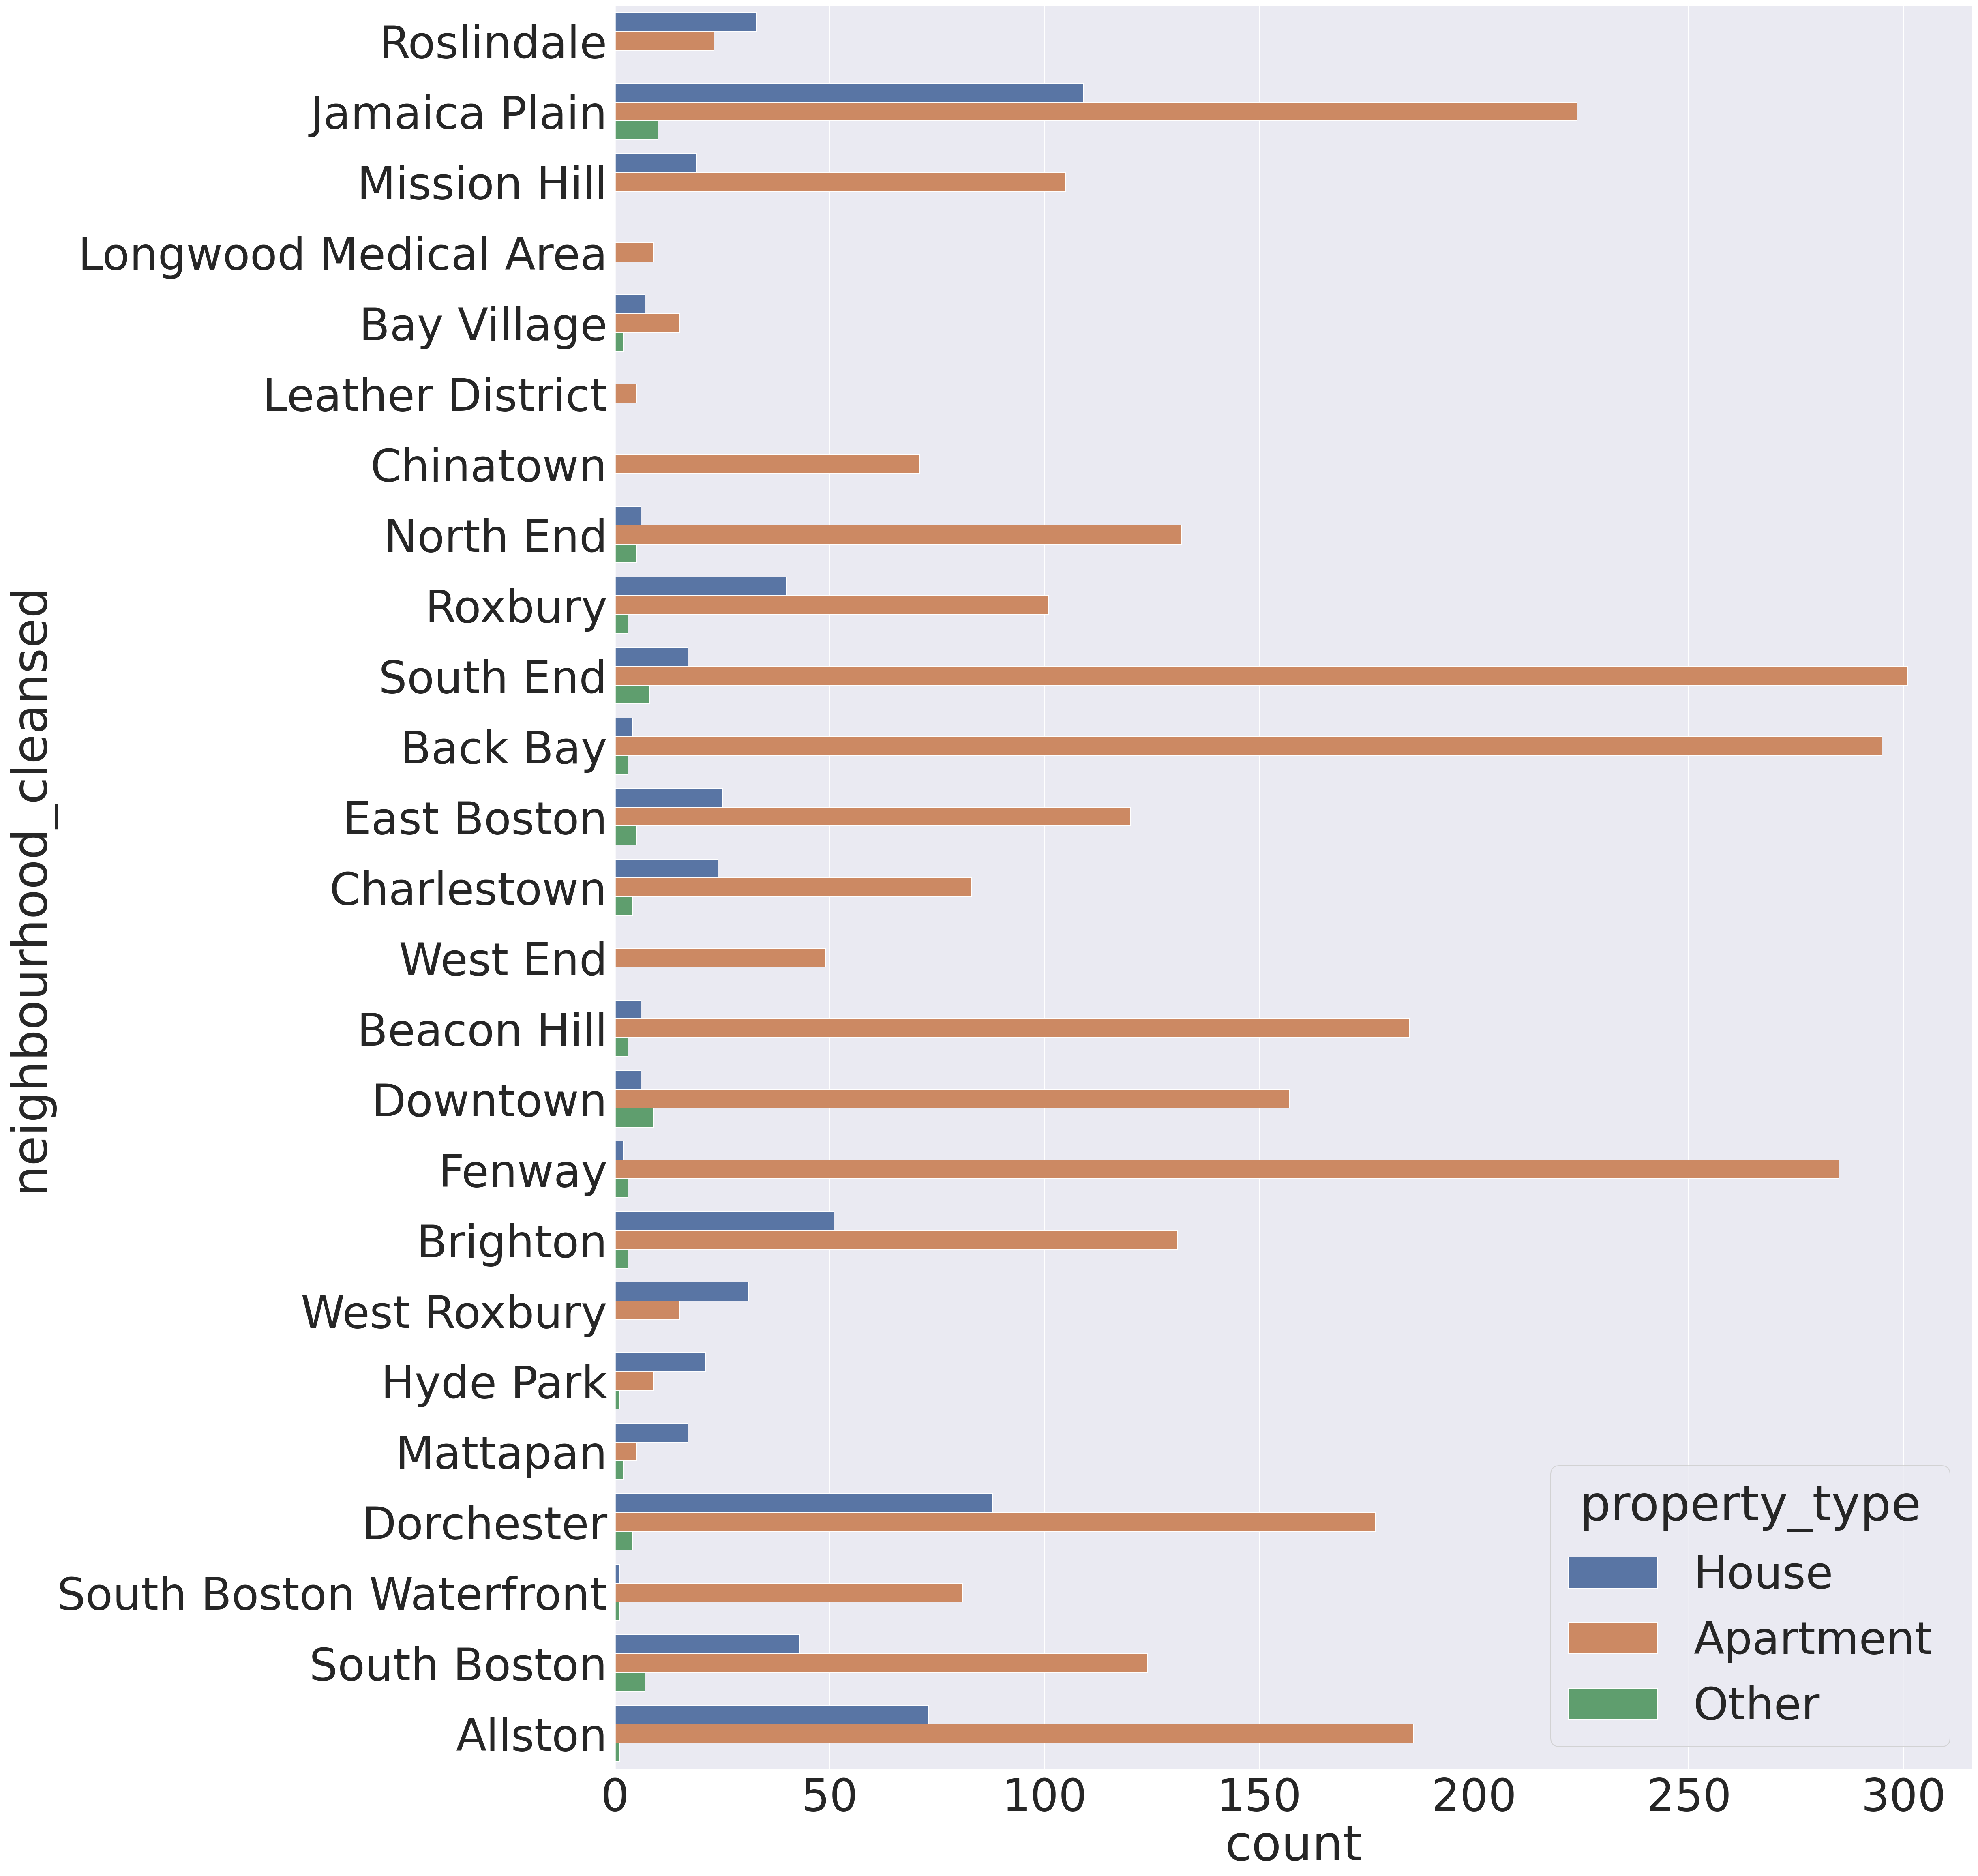

In [36]:
fig = plt.gcf()

# Change seaborn plot size & font size
fig.set_size_inches(30, 40)

sns.set(font_scale=5)
# copy columns into a new dataframe 
property_df = listings_1st_clean[['neighbourhood_cleansed', 'property_type']].copy()
property_df.head(1)

sns.countplot(y = "neighbourhood_cleansed", hue = "property_type", data=property_df)


**Comment:** We can see that Leather District has little listing of apartments and no house nor other types of listings. This might explained why the average rating is the highest here.

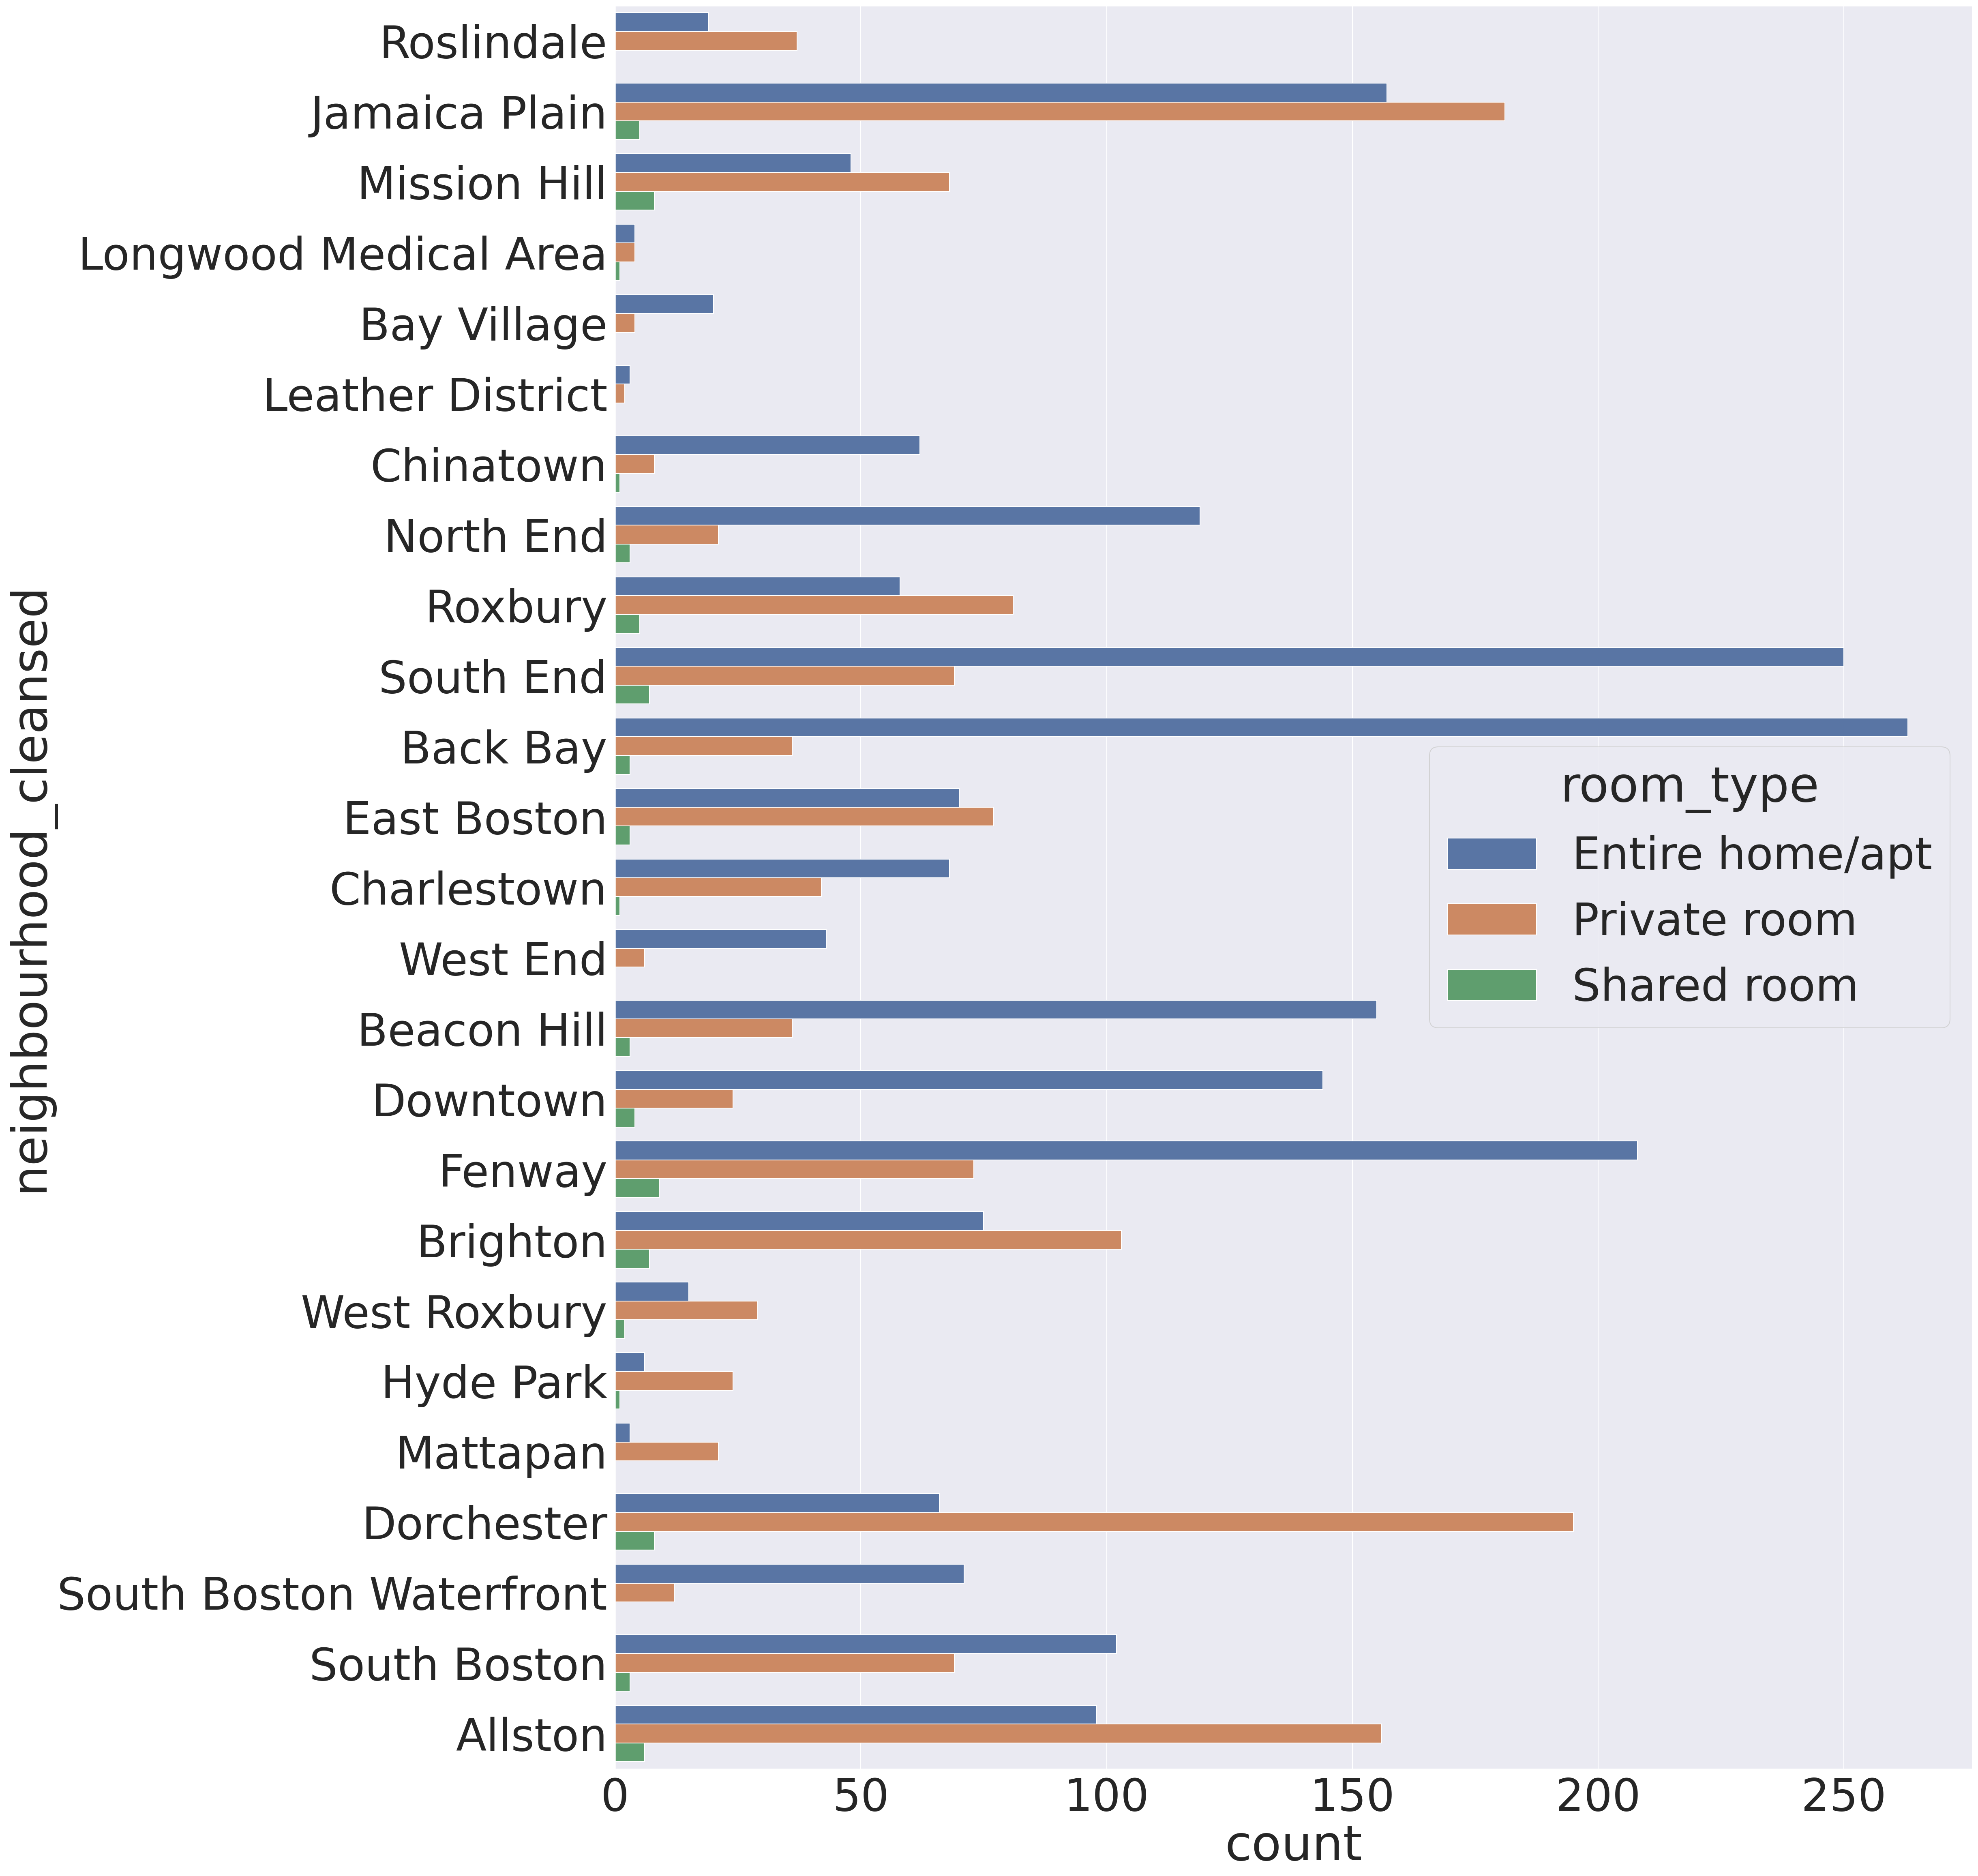

In [37]:
fig = plt.gcf()

# Change seaborn plot size & font size
fig.set_size_inches(30, 40)

sns.set(font_scale=5)
# copy columns into a new dataframe 
room_df = listings_1st_clean[['neighbourhood_cleansed', 'room_type']].copy()

sns.countplot(y = "neighbourhood_cleansed", hue = "room_type", data=room_df)

**Comment:** As shown in the plot, there is no shared room option in Leather District, therefore people can have more privacy staying at an airbnb there by having an entire apartment to themselves or having a private room.

In [38]:
#check again if there are missing values
listings_1st_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3585 non-null   int64  
 1   host_response_rate              3585 non-null   object 
 2   host_is_superhost               3585 non-null   int64  
 3   host_identity_verified          3585 non-null   int64  
 4   neighbourhood_cleansed          3585 non-null   object 
 5   latitude                        3585 non-null   float64
 6   longitude                       3585 non-null   float64
 7   is_location_exact               3585 non-null   int64  
 8   property_type                   3585 non-null   object 
 9   room_type                       3585 non-null   object 
 10  accommodates                    3585 non-null   int64  
 11  bathrooms                       3585 non-null   float64
 12  bedrooms                        35

## Spatial data

In [39]:
# installing geopandas
!pip install geopandas

### a.Plot listings on the city map with different colours corresponding to the listing’s neighbourhood

In [40]:
import geopandas as gpd

# read a shape file of Boston (https://bostonopendata-boston.opendata.arcgis.com/datasets/zoning-districts/data)
boston_gdf = gpd.read_file('./data/boston/Zoning_Districts.shp')
boston_gdf.head(1)

OBJECTID_1  ...                                           geometry
0         474  ...  POLYGON ((-71.07214 42.38366, -71.07169 42.383...

[1 rows x 9 columns]

In [41]:
# set new index
district = boston_gdf.set_index(['DISTRICT'])

# change to projected referance system EPSG:26923 (http://epsg.io/26923)
district = district.to_crs('EPSG:26923')

In [42]:
import shapely

# create a GeoDataFrame 
listings_gdf = gpd.GeoDataFrame(listings_df.drop(['longitude', 'latitude'], axis=1), crs={'init': 'epsg:4326'}, 
                       geometry=[shapely.geometry.Point(xy) for xy in zip(listings_df.longitude, listings_df.latitude)])

listings_gdf.head(1)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


id  ...                    geometry
0  12147973  ...  POINT (-71.13307 42.28262)

[1 rows x 94 columns]

In [43]:
# Convert the data to projected CRS for plotting
listings_gdf = listings_gdf.to_crs('EPSG:26923')
listings_gdf.crs

<Projected CRS: EPSG:26923>
Name: NAD83 / UTM zone 23N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada offshore Atlantic - east of 48°W.
- bounds: (-48.0, 46.46, -47.74, 49.18)
Coordinate Operation:
- name: UTM zone 23N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

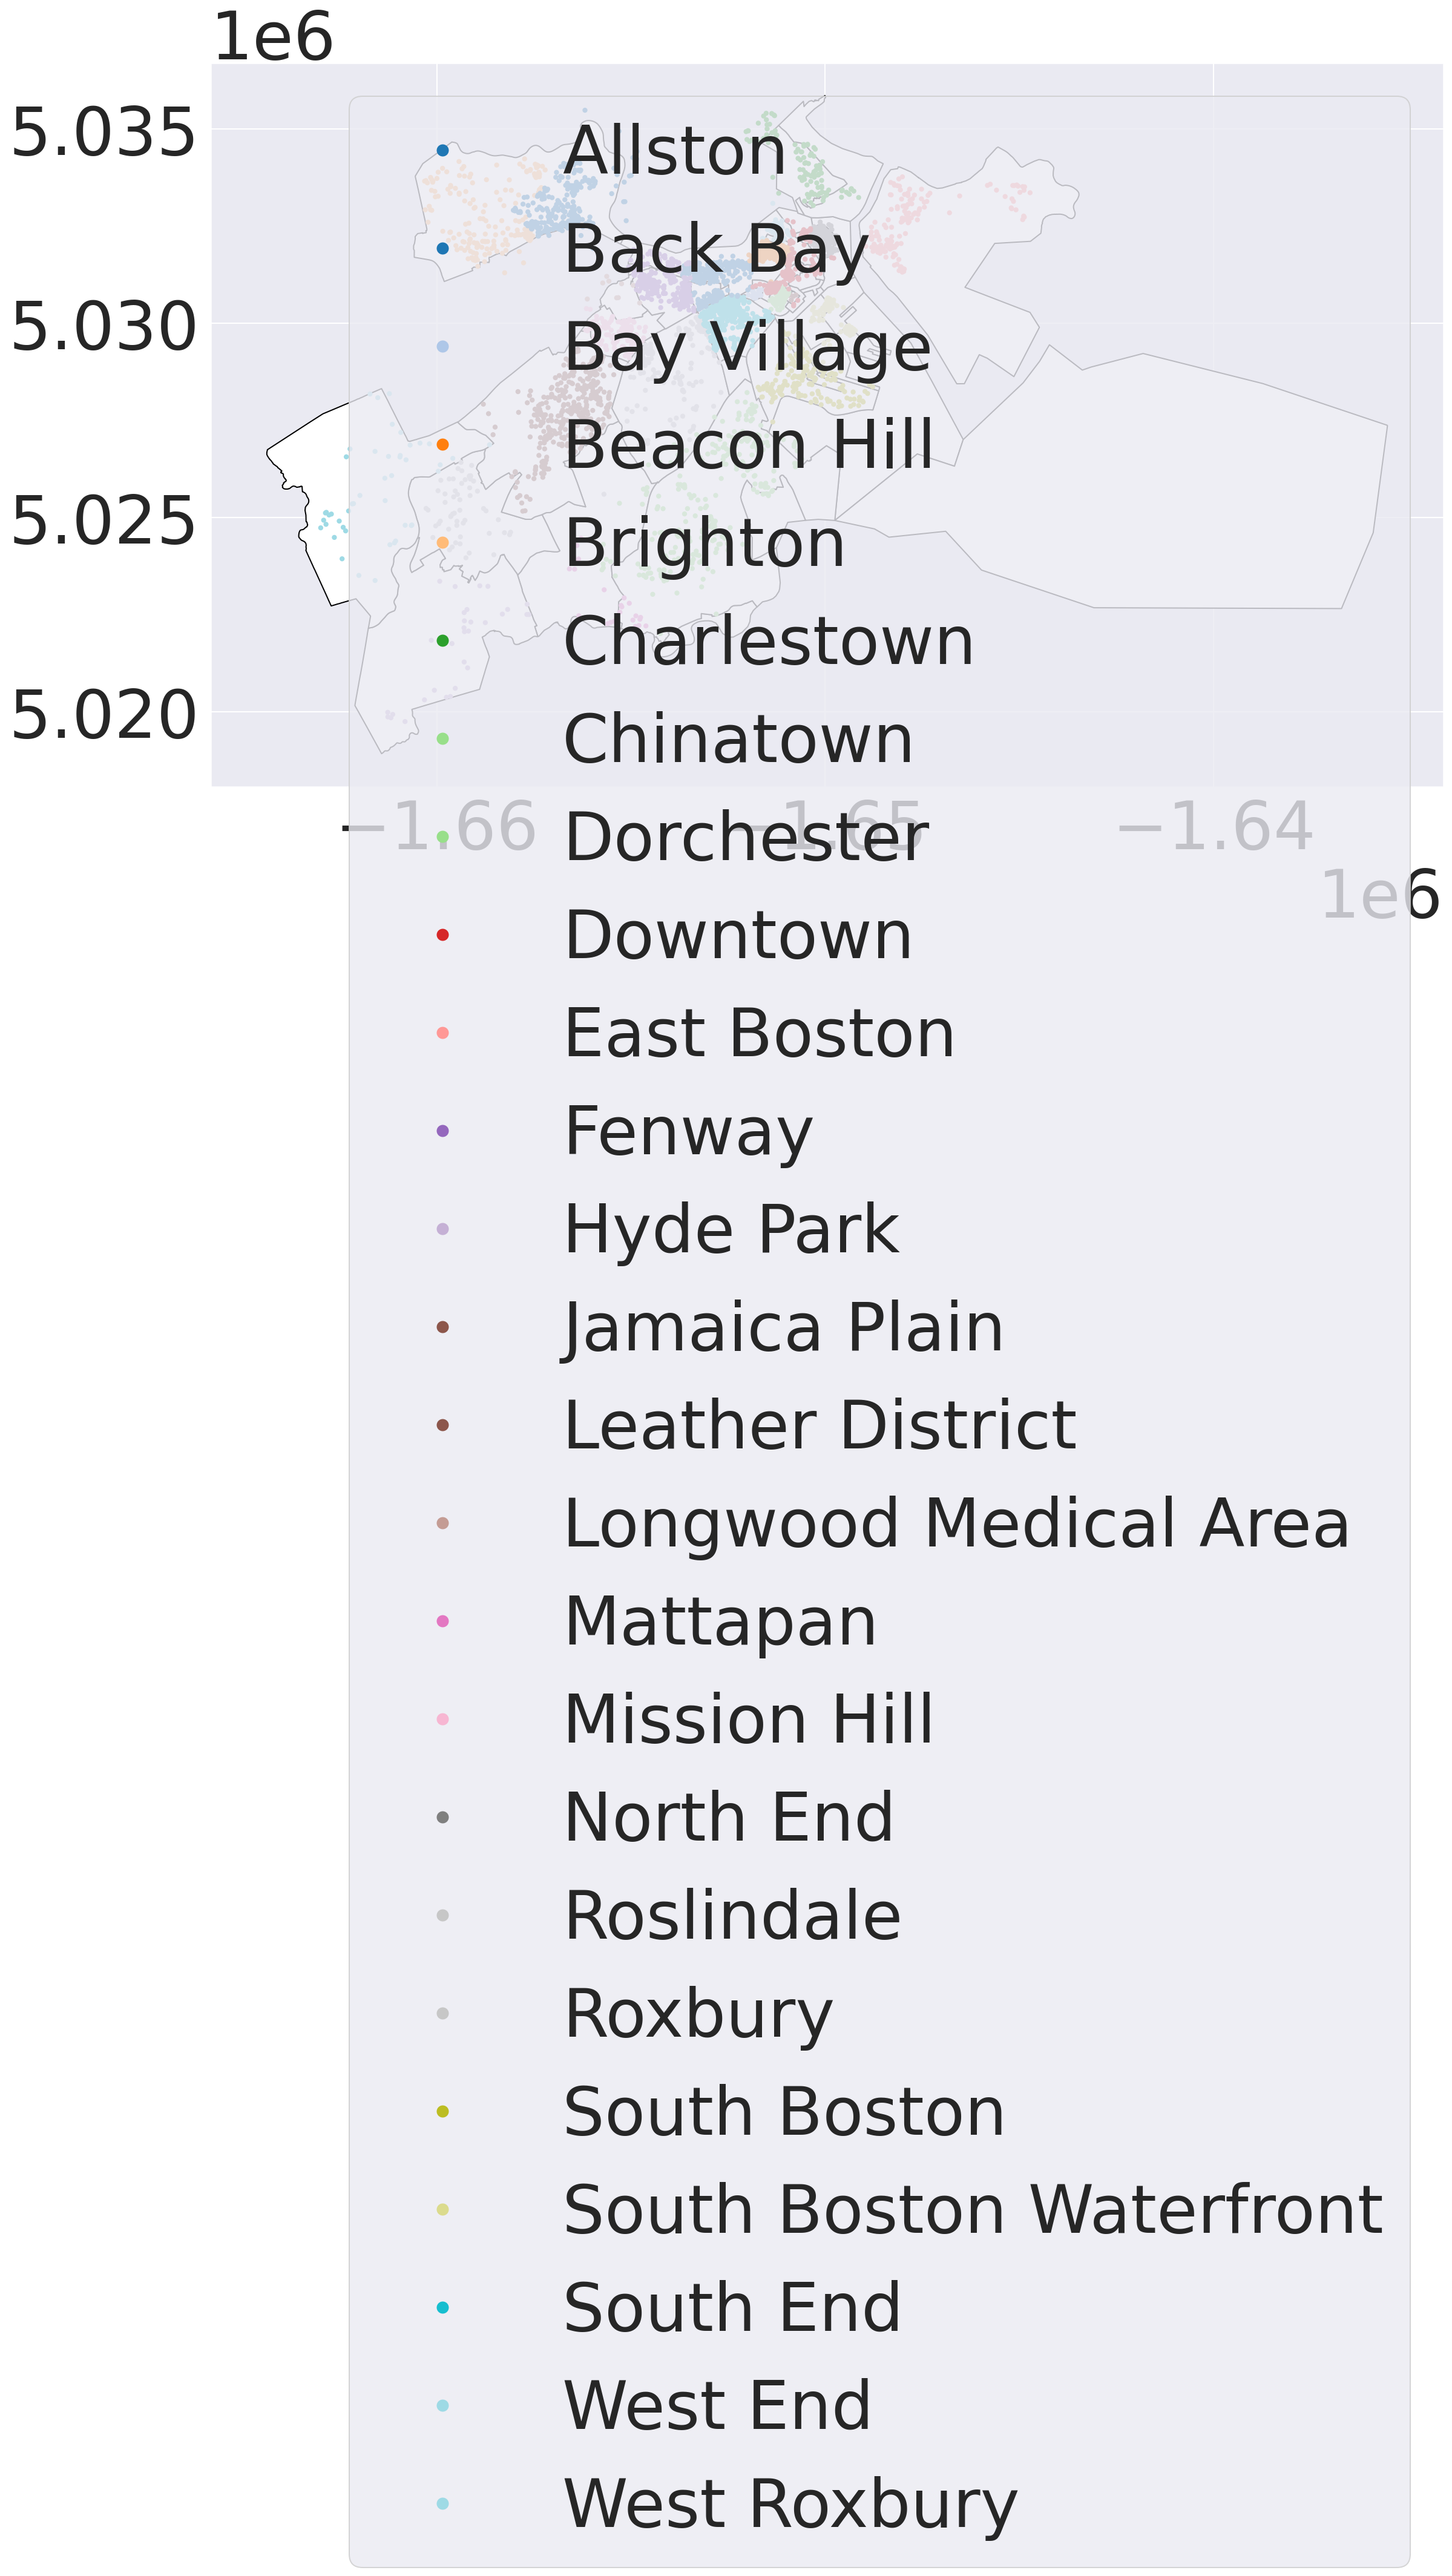

In [44]:
geo_df_ = listings_gdf

#creating color map for categories
categories = np.unique(geo_df_["neighbourhood_cleansed"])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))

#matching it to the geopandas df
geo_df_["Color"] = geo_df_["neighbourhood_cleansed"].apply(lambda x: colordict[x])

#plotting    
ax = district.plot(figsize=(20,11),color="white",edgecolor="black")
geo_df_.plot(ax=ax, marker='o', column=geo_df_["neighbourhood_cleansed"], categorical=True,
             markersize=10, legend=True, cmap='tab20')

**Comment:** From the plot, we can see that some points which were labeled as the same neighbourhoond are plotted in more than one district. There also are some points being plotted outside the boundary. Those might be caused by missclassifacations when hosts created the profile of their properties. Indeed, most of those missclassifications were happened around the most popualar areas in Boston. Thus, we might infer that the host would intened to do so to increase the competitiveness of their properties.

### b.Mark the “State station” (lat, long = 42.3570174,-71.071191) subway station onthe city map.

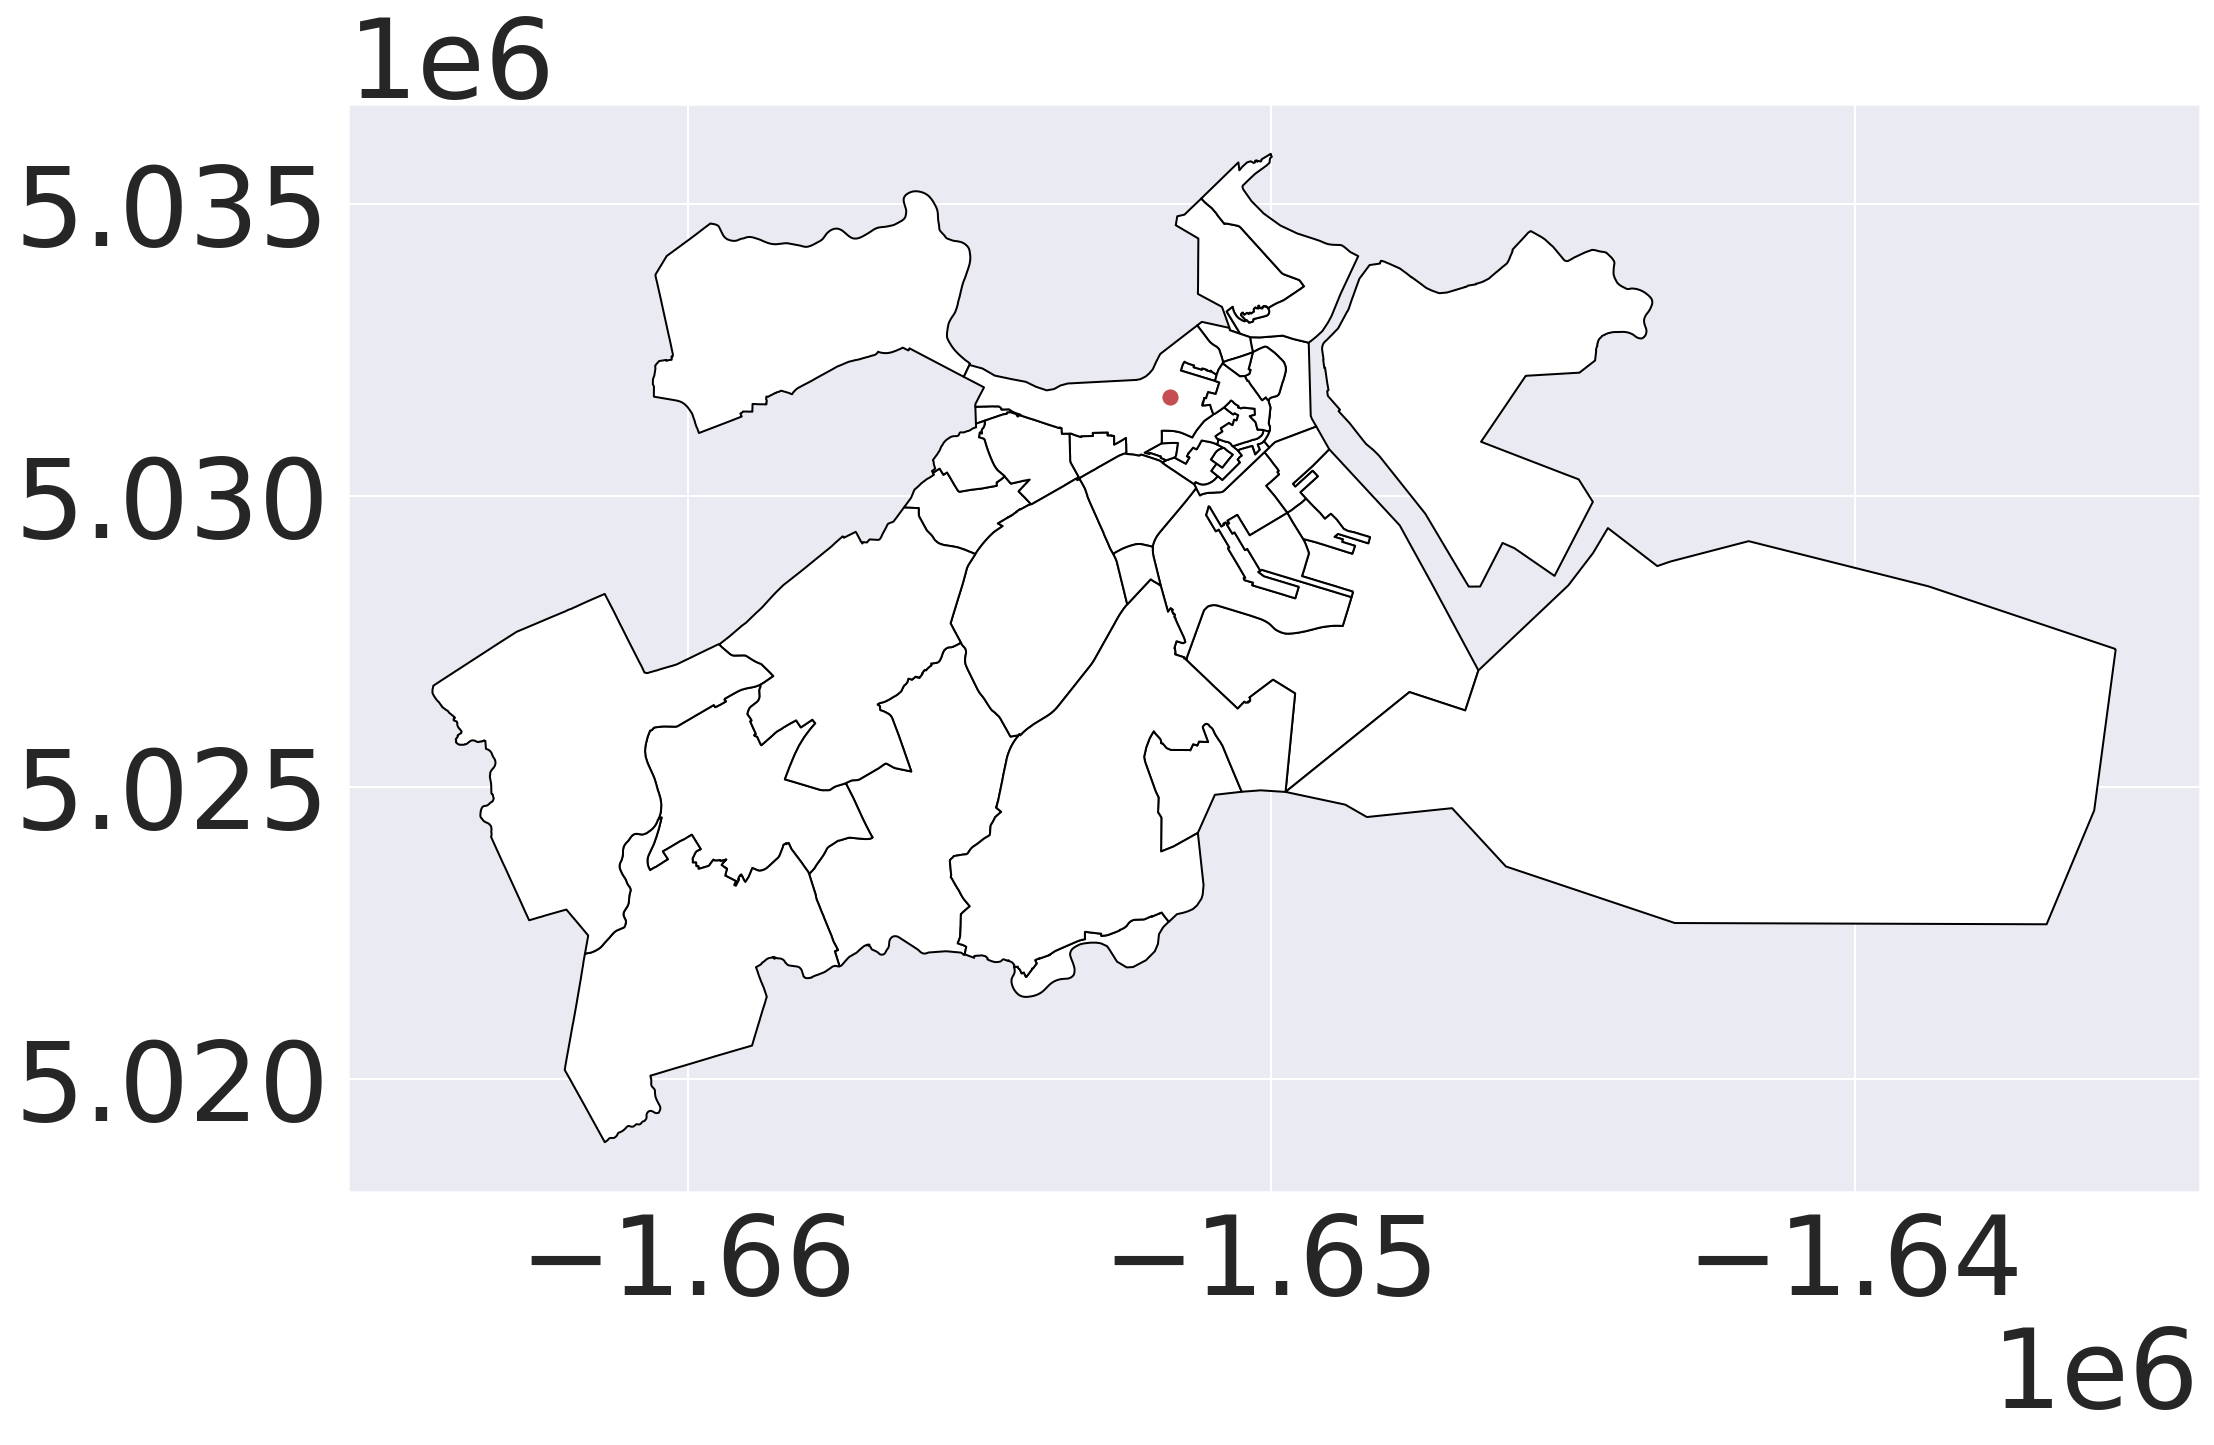

In [45]:
from shapely.geometry import Point

#create a new point coordinate
subway_station = [Point(-71.071191,42.3570174)]

subway_station_gpd = gpd.GeoDataFrame(geometry=subway_station, index=['State station'])
subway_station_gpd.crs = "EPSG:4326"

subway_station_gpd = subway_station_gpd.to_crs('EPSG:26923')

#plot the point on the city map
ax = district.plot(figsize=(20,10),color="white",edgecolor="black")
gpd.GeoSeries(subway_station_gpd["geometry"][0]).plot(ax=ax,c="r",markersize=50)

**Comment:** This Station state is located within 'Boston Proper' district.

### c.Plot the distance between the closest and most distant listings to State station.

In [46]:
!pip install geopy

In [47]:
import geopy.distance
from shapely.geometry import LineString

dist = np.array([])
#(latitude,longitude)
for i in range(listings_df.shape[0]):
  latitude = listings_df['latitude'][i]
  longitude = listings_df['longitude'][i]
  d = geopy.distance.distance((42.3570174,-71.071191) , (latitude,longitude)).km
  dist = np.append(dist,d)

closest = (np.where(dist == dist.min()))[0][0] #return an index
farest = (np.where(dist == dist.max()))[0][0]

#points objects
p_station = subway_station_gpd["geometry"][0]
p_closest = listings_gdf["geometry"][closest]
p_farest = listings_gdf["geometry"][farest]

#### Plot the distance from the State station to the closet Airbnb


Distance:  0.016236694416701215


(5030600.0, 5033000.0)

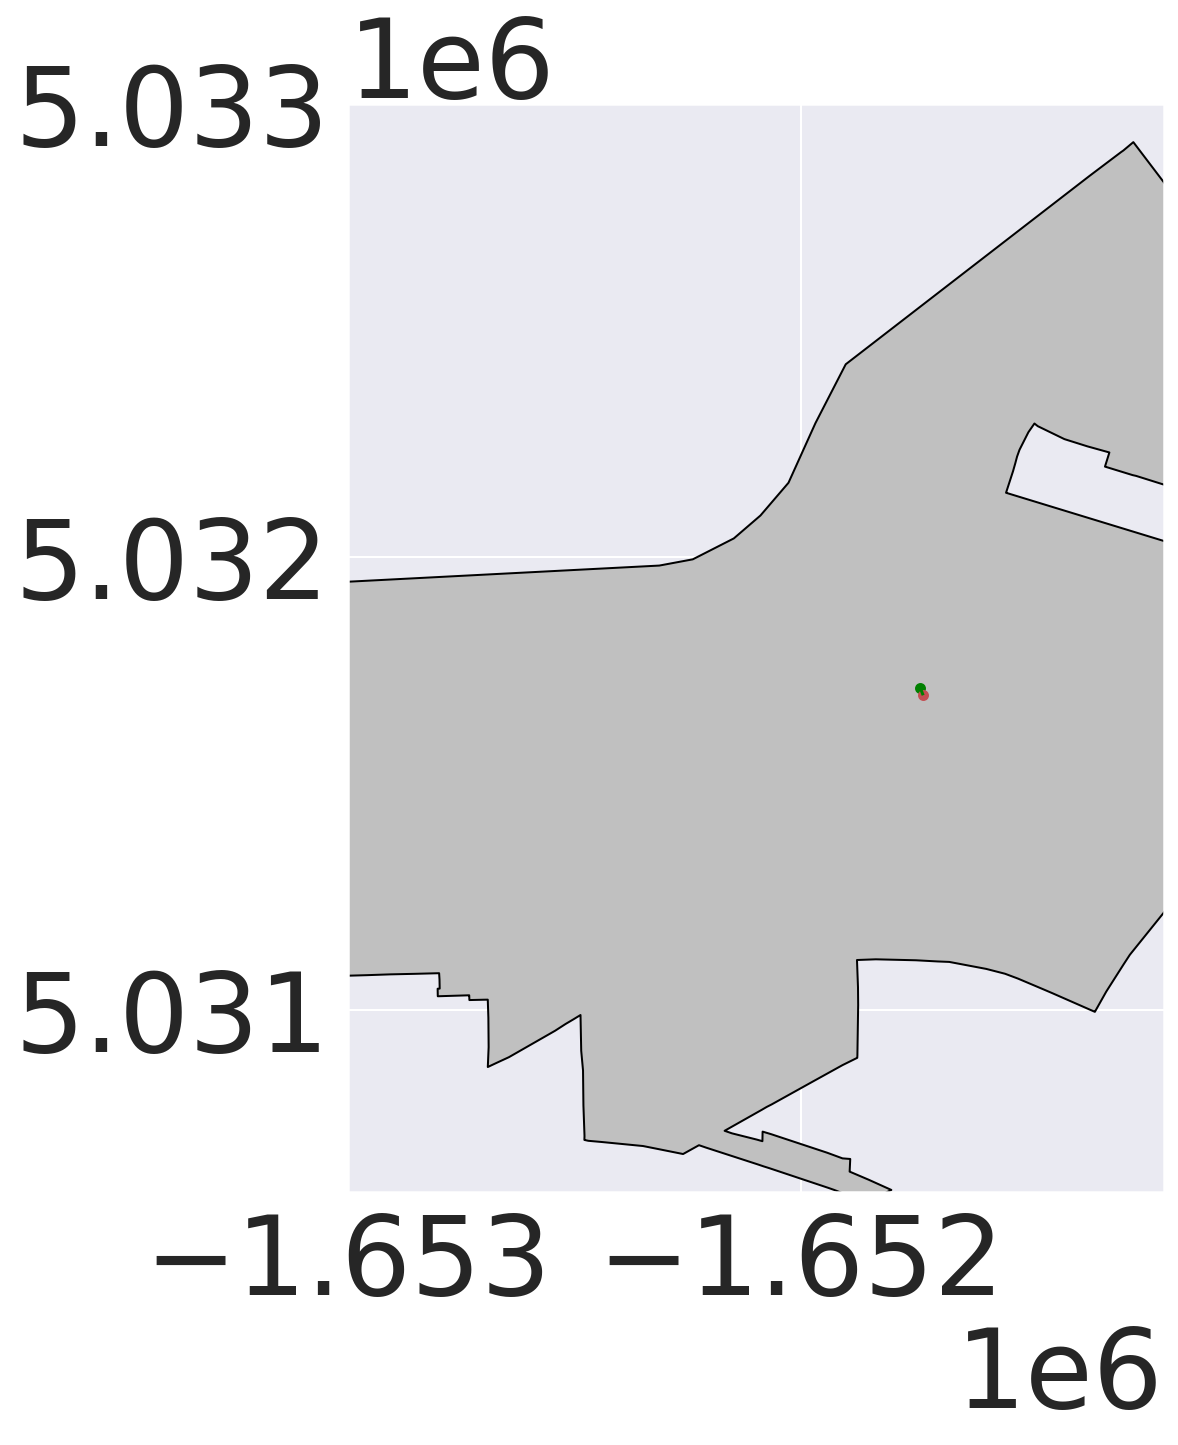

In [48]:
print("Distance: ",dist.min())

#plot the closest point point on the city map
ax = district.loc[['Boston Proper'],:].plot(figsize=(20,10),color="silver",edgecolor="black")
gpd.GeoSeries([listings_gdf["geometry"][closest]]).plot(ax=ax,c="green",markersize=20)
gpd.GeoSeries(subway_station_gpd["geometry"][0]).plot(ax=ax,c="r",markersize=20)

#plot distances
line1 = LineString([(p_station.x,p_station.y),(p_closest.x,p_closest.y)])
gpd.GeoDataFrame(geometry=[line1]).plot(ax=ax,color="green")

#set boundaries
xlim = ([-1.6530*10**6,-1.6512*10**6])
ylim = ([5.0306*10**6,5.0330*10**6])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

**Comment:** The closest property is 0.016236694416701215 km away from the Station state. It's hard to plot the distance between them as they are too close.

#### Plot the distance from the State station to the farest Airbnb

Distance:  14.366866344722617


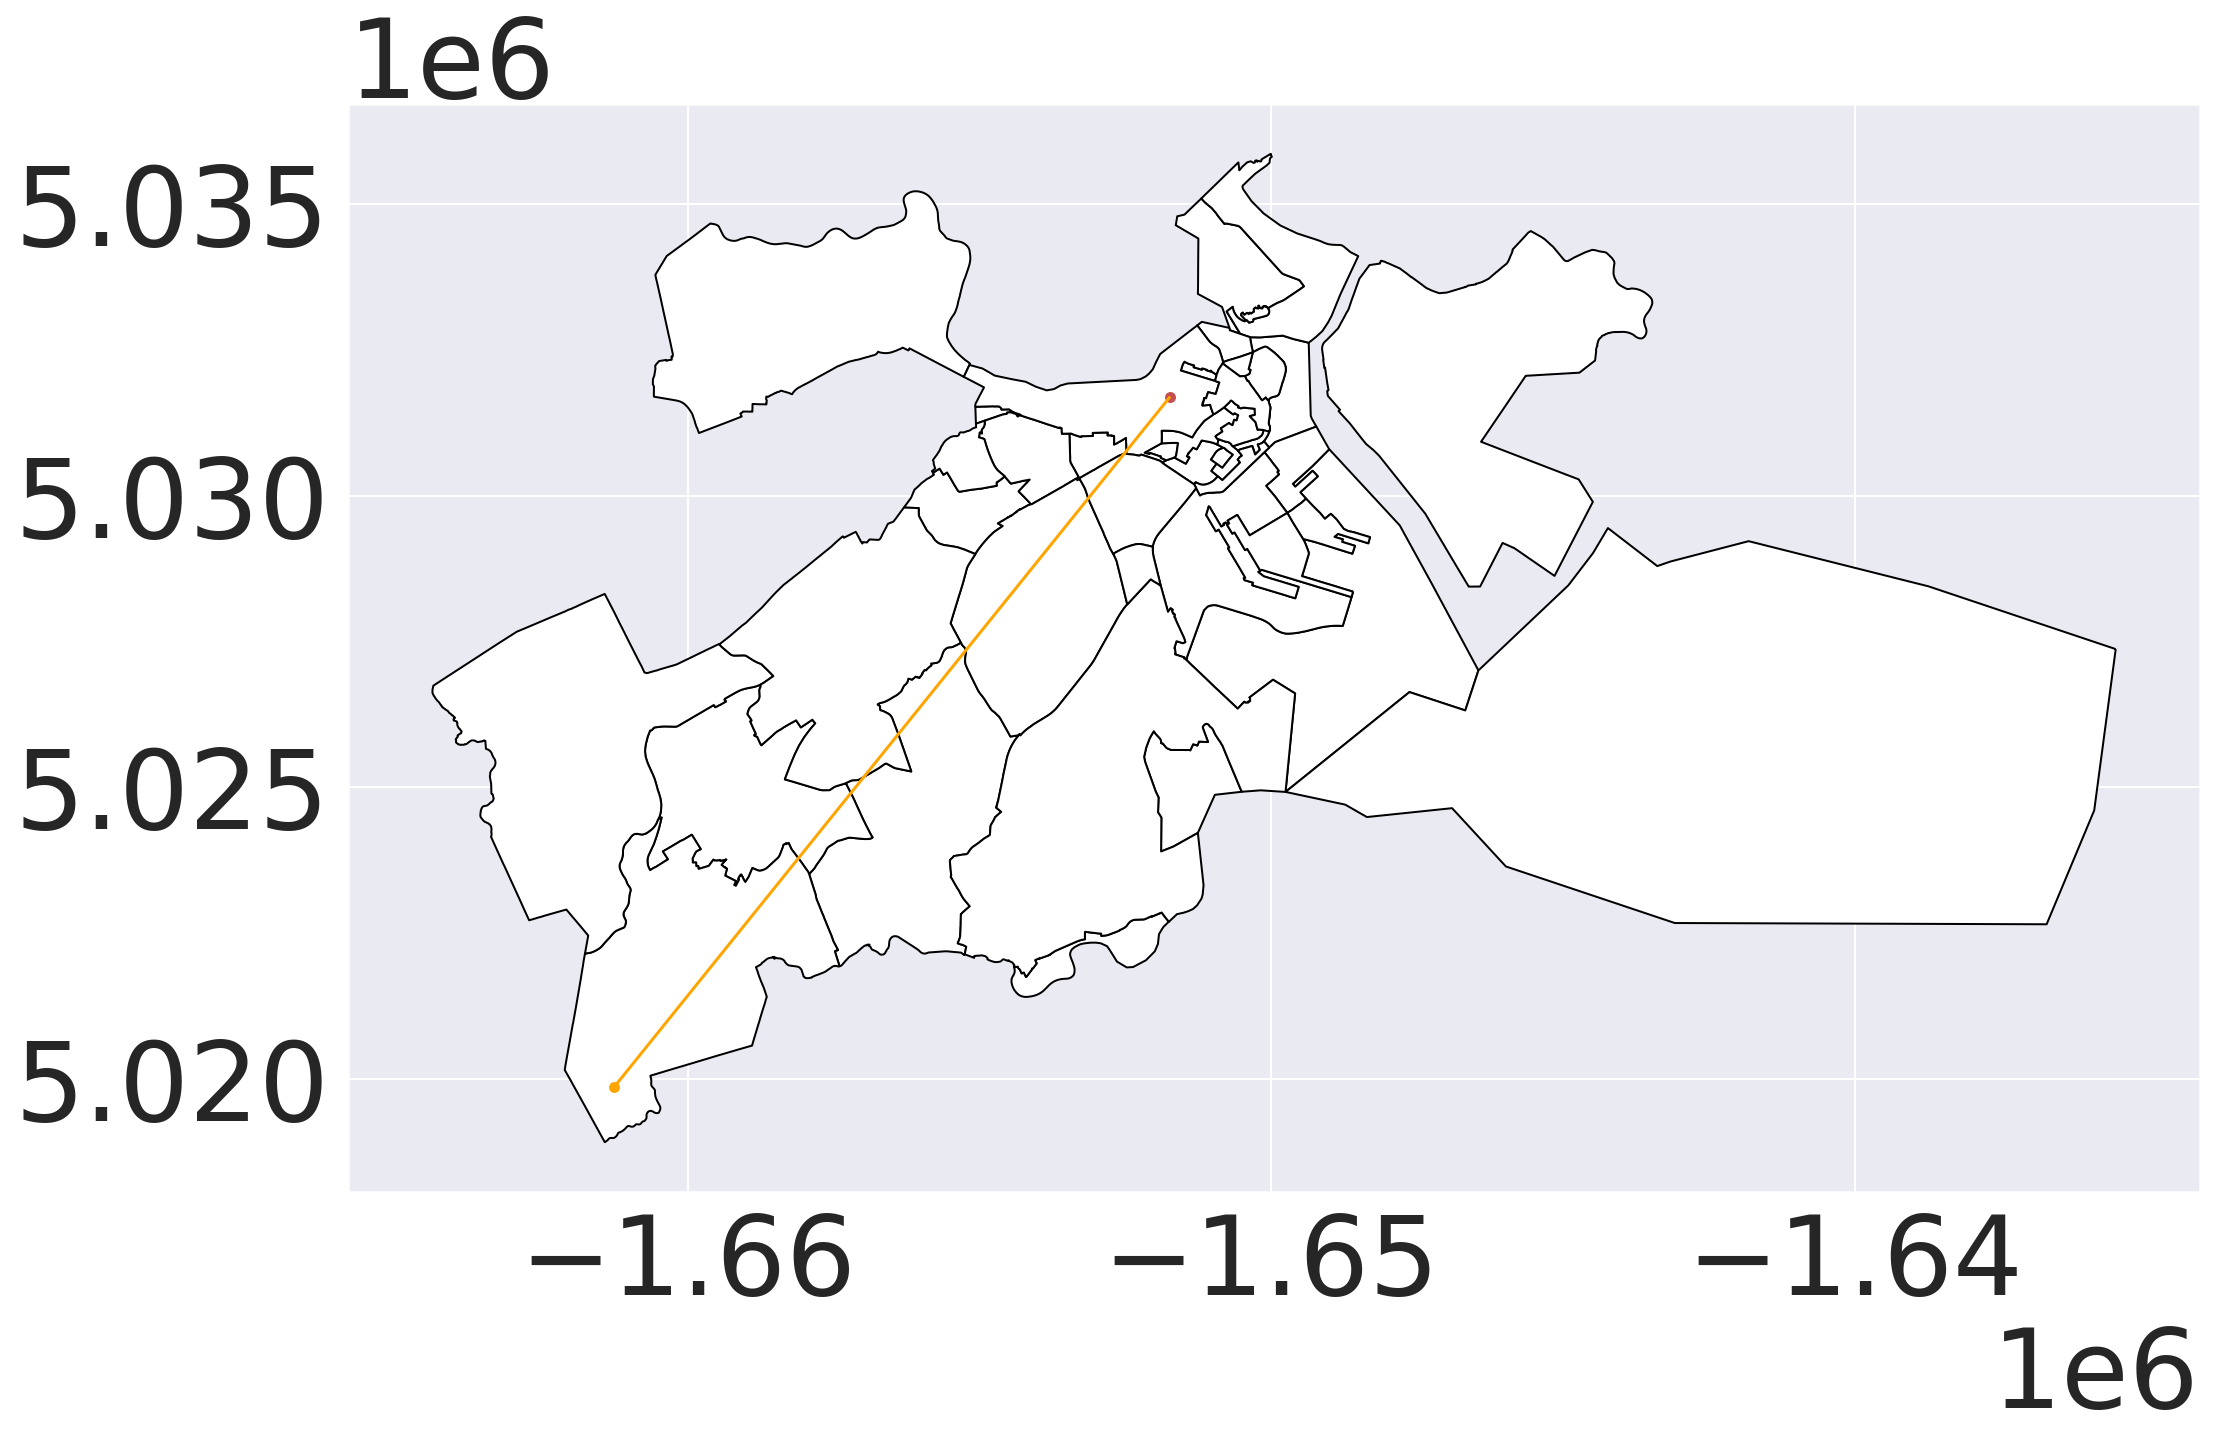

In [49]:
print("Distance: ",dist.max())

#plot the closest point point on the city map
ax = district.plot(figsize=(20,10),color="white",edgecolor="black")
gpd.GeoSeries([listings_gdf["geometry"][farest]]).plot(ax=ax,c="orange",markersize=20)
gpd.GeoSeries(subway_station_gpd["geometry"][0]).plot(ax=ax,c="r",markersize=20)

#plot distances
line2 = LineString([(p_station.x,p_station.y),(p_farest.x,p_farest.y)])
gpd.GeoDataFrame(geometry=[line2]).plot(ax=ax,color="orange")

**Comment:** The farest property is located within 'Hyde Park Neighborhood' district and is 14.366866344722617 km away from the Station state.

## Data Transformation & Modelling

In [50]:
# One-Hot encoding Categorical Features
listings_transformed = pd.get_dummies(listings_1st_clean)

In [51]:
listings_transformed.head(1)

id  ...  cancellation_policy_super_strict_30
0  12147973  ...                                    0

[1 rows x 67 columns]

In [52]:
with pd.option_context('display.float_format', '{:.2f}'.format):
  display(buildContinuousFeaturesReport(listings_transformed.select_dtypes('number').columns.to_list(), listings_transformed))

Count  Miss %  ...         Max  Std. Dev.
id                                    3585    0.00  ... 14933461.00 4500786.86
host_is_superhost                     3585    0.00  ...        1.00       0.32
host_identity_verified                3585    0.00  ...        1.00       0.45
latitude                              3585    0.00  ...       42.39       0.02
longitude                             3585    0.00  ...      -71.00       0.03
...                                    ...     ...  ...         ...        ...
room_type_Shared room                 3585    0.00  ...        1.00       0.15
cancellation_policy_flexible          3585    0.00  ...        1.00       0.45
cancellation_policy_moderate          3585    0.00  ...        1.00       0.44
cancellation_policy_strict            3585    0.00  ...        1.00       0.50
cancellation_policy_super_strict_30   3585    0.00  ...        1.00       0.15

[67 rows x 10 columns]

### Feature Selection

Using chi squared statistical test for the positive features to select the 15 best features from the dataset.

We exclude the ratings for now. latitude and longitude has too much cardinality and negative values, therefore they are also excluded from feature selection

In [53]:
#referenced from https://bit.ly/2IRxHE6 (shortened url)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = listings_transformed.drop(['id','price', 'latitude','longitude', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'], axis=1)
y = listings_transformed.price

# Apply SelectKBest class to extract top 15 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))

                                  Specs          Score
15       calculated_host_listings_count  152474.921390
7                      security_deposit   66201.887836
12                     availability_365   51090.663301
8                          cleaning_fee   32953.950248
13                    number_of_reviews   30801.366595
10                         extra_people   14669.492404
11                       minimum_nights   11254.846996
3                          accommodates    1676.377694
55  cancellation_policy_super_strict_30    1493.890977
50               room_type_Private room    1246.427889
49            room_type_Entire home/apt     896.262065
19            host_response_rate_90-99%     762.291158
6                                  beds     759.360562
9                       guests_included     682.540386
22      neighbourhood_cleansed_Back Bay     666.385233


In [54]:
# make a new dataframe with only selected features
new_df = listings_transformed[['calculated_host_listings_count', 'security_deposit','availability_365','cleaning_fee',
                             'number_of_reviews','extra_people','minimum_nights','accommodates',
                               'cancellation_policy_super_strict_30',
                             'room_type_Private room','room_type_Entire home/apt','host_response_rate_90-99%',
                               'beds','guests_included','price']].copy()

In [55]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   calculated_host_listings_count       3585 non-null   int64  
 1   security_deposit                     3585 non-null   float64
 2   availability_365                     3585 non-null   int64  
 3   cleaning_fee                         3585 non-null   float64
 4   number_of_reviews                    3585 non-null   int64  
 5   extra_people                         3585 non-null   float64
 6   minimum_nights                       3585 non-null   int64  
 7   accommodates                         3585 non-null   int64  
 8   cancellation_policy_super_strict_30  3585 non-null   uint8  
 9   room_type_Private room               3585 non-null   uint8  
 10  room_type_Entire home/apt            3585 non-null   uint8  
 11  host_response_rate_90-99%     

In [56]:
numerical_columns = ['accommodates', 'availability_365', 'cleaning_fee', 'extra_people', 'calculated_host_listings_count', 'minimum_nights', 'number_of_reviews', 'price','security_deposit']

In [57]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_365']] # Removing items not to be transformed

for col in numerical_columns:
    new_df[col] = new_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01 to avoid null values
    new_df[col] = np.log(new_df[col])

### Baseline: Lasso Regression Model with Cross Validation

In [58]:
#referenced from https://vitalflux.com/lasso-ridge-regression-explained-with-python-example/
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
#
X = new_df.drop(['price'], axis=1)
y = new_df.price
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
# Create an instance of Lasso Regression implementation
#
lasso_cv = LassoCV(cv=10)
#
# Fit the Lasso model
#
lasso_cv.fit(X, y)
#
# Create the model score
#
lasso_cv.score(X_train, y_train), lasso_cv.score(X_test, y_test)

(0.5684061286031704, 0.5778312023383836)

We could see that Lasso regression is not performing too well right now, the dataset is not big enough to perform large fold CV.

### Learning Curve for LassoCV

(0.0, 1.0)

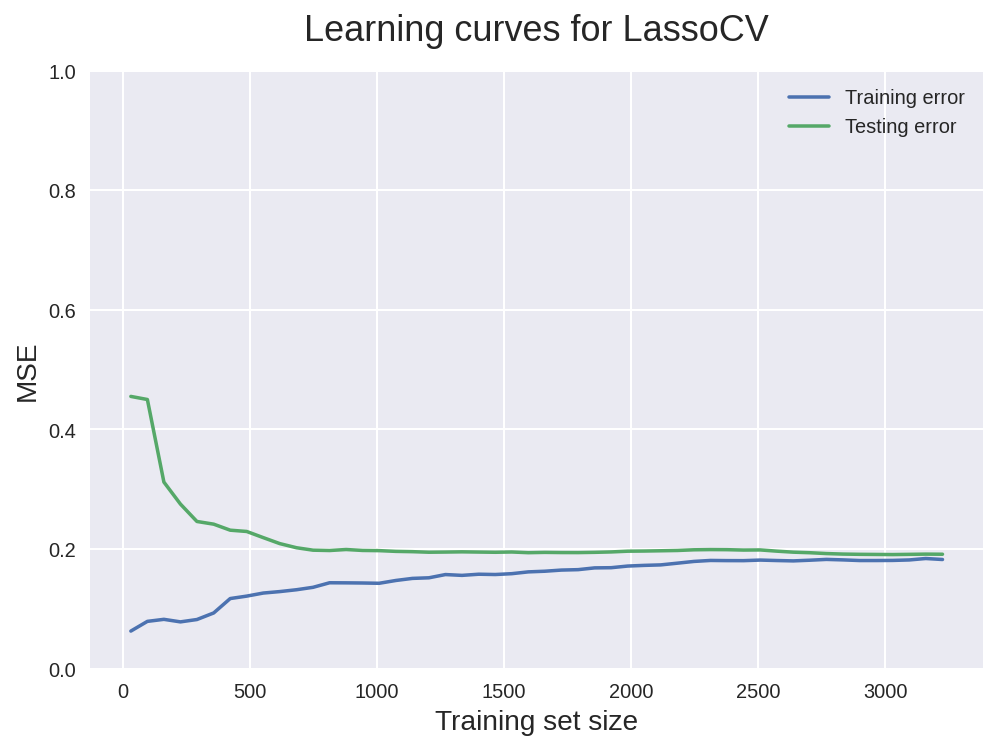

In [59]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.01, 1.0, 50)
train_sizes, train_scores, test_scores = learning_curve(LassoCV(), X, y, 
                                                        train_sizes = train_sizes, cv = 10, 
                                                        scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
test_scores_mean = -test_scores.mean(axis = 1)

#plot
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, test_scores_mean, label = 'Testing error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for LassoCV', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,1)

**Comment:** We take MSE as the measurement of model's performance.


### Final Model using XGBoost

In [60]:
X = new_df.drop(['price'], axis=1)
y = new_df.price

In [61]:
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [62]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [63]:
xgb_reg_start = time.time()

#use default hyperparams
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

[01:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [64]:
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 0.1423
Validation MSE: 0.1546

Training r2: 0.6699
Validation r2: 0.6215


**Comment** Here I am using the default hyperparameters in my XBBoost. R^2 score indicates the amount of the variation in the output dependent attribute which is predictable from the input independent variables. If the model always predict the target, the R^2 score will be 1. If model gives same results everytime but it does not alway make the prediction right, the R^2 value is 0. The training R^2 measure is over 0.95, but the validation R^2 is much smaller, which means the model is actually overfitting, therefore, more hyperparameter tuning is needed here.

We can also have a look at the RMSE measure below and compare it later

In [65]:
preds = xgb_reg.predict(X_test)

In [66]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.393150


### Hyperparameter Tuning for XGBoost

**Comment:** After doing some research on the hyperparameters in XGBRegressor, a few deterministic hyperparameter we decided on is alpha, max_depth, colsample_bytree, n_estimators and learning rate.

definitions from https://xgboost.readthedocs.io/en/latest/parameter.html
https://xgboost.readthedocs.io/en/latest/python/python_api.html

**alpha** stands for the L1 regularization term on weights. Increasing this value will make model more conservative.

**max_depth** Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

**colsample_bytree** is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

**n_estimators** Number of gradient boosted trees. Equivalent to number of boosting rounds.

**learning rate** Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

In [67]:
# For Cross Validation
cv_set = new_df

In [68]:
# Cross Validation Set
#move price column to the last column
cv_set = cv_set[[col for col in cv_set if col not in ['price']] 
       + ['price']]

In [69]:
cv_set.head()

calculated_host_listings_count  security_deposit  ...  guests_included     price
0                             0.0          5.782896  ...                1  5.521461
1                             0.0          4.553877  ...                0  4.174387
2                             0.0          5.782896  ...                1  4.174387
3                             0.0          4.605170  ...                2  4.317488
4                             0.0          5.782896  ...                1  4.369448

[5 rows x 15 columns]

In [70]:
X_cv, y_cv = cv_set.loc[:,'calculated_host_listings_count':'guests_included'], cv_set.loc[:,'price']
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_cv, y_cv, test_size = 0.3, random_state = 0)

In [71]:
# DMatrix
data_dmatrix = xgb.DMatrix(data=X_cv_train,label=y_cv_train)

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [72]:
from sklearn import preprocessing
preprocessing.LabelEncoder().fit_transform(y_cv_train)
preprocessing.LabelEncoder().fit_transform(y_cv_test)

array([ 33, 171,  39, ...,  81, 141,  71])

In [73]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_cv_train, y_cv_train), ( X_cv_test, y_cv_test)]
    
    clf.fit(X_cv_train, y_cv_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_cv_test)
    accuracy = accuracy_score(y_cv_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [74]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


ValueError: ignored

**Comment**: we are not sre why this approach is not working.(referenced from https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning) After research it could be encoding problems with the labels. Due to time limit, we are switching tactics and performing manual hyperparameter tuning.

### k-fold Cross Validation with XGBoost

In [75]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.8,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 5, 'min_child_weight': 2}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=7,
                    num_boost_round=500,early_stopping_rounds=250,metrics="rmse", as_pandas=True, seed=1000)

In [76]:
print((cv_results["test-rmse-mean"]).tail(1))

195    0.394909
Name: test-rmse-mean, dtype: float64


In [77]:
# rmse results for each boosting round
cv_results.tail(1)

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
195         0.315598        0.002595        0.394909       0.020234

### After Hyperparameter Tuning for XGboost

In [78]:
xgb_reg_start = time.time()

#use default hyperparams
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror',colsample_bytree = 0.2,learning_rate = 0.1,
                max_depth = 10, alpha = 7, min_child_weight = 2, n_estimators = 500)

xgb_reg.fit(X_train, y_train)

training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Time taken to run: 0.0 minutes

Training MSE: 0.0569
Validation MSE: 0.1634

Training r2: 0.868
Validation r2: 0.6


In [79]:
preds = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.404195


### Models with ratings taking into account

In [80]:
new_df_with_rating = listings_transformed[['calculated_host_listings_count', 'security_deposit','availability_365','cleaning_fee',
                             'number_of_reviews','extra_people','minimum_nights','accommodates',
                               'cancellation_policy_super_strict_30',
                             'room_type_Private room','room_type_Entire home/apt','host_response_rate_90-99%',
                               'beds','guests_included','review_scores_rating', 'review_scores_accuracy',
                               'review_scores_cleanliness', 'review_scores_checkin',
                               'review_scores_communication', 'review_scores_location','review_scores_value','price']].copy()

In [81]:
new_df_with_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   calculated_host_listings_count       3585 non-null   int64  
 1   security_deposit                     3585 non-null   float64
 2   availability_365                     3585 non-null   int64  
 3   cleaning_fee                         3585 non-null   float64
 4   number_of_reviews                    3585 non-null   int64  
 5   extra_people                         3585 non-null   float64
 6   minimum_nights                       3585 non-null   int64  
 7   accommodates                         3585 non-null   int64  
 8   cancellation_policy_super_strict_30  3585 non-null   uint8  
 9   room_type_Private room               3585 non-null   uint8  
 10  room_type_Entire home/apt            3585 non-null   uint8  
 11  host_response_rate_90-99%     

In [82]:
numerical_columns = ['accommodates', 'availability_365', 'cleaning_fee', 'extra_people', 'calculated_host_listings_count', 
                     'minimum_nights', 'number_of_reviews', 'price','security_deposit','review_scores_rating', 'review_scores_accuracy',
                               'review_scores_cleanliness', 'review_scores_checkin',
                               'review_scores_communication', 'review_scores_location','review_scores_value']

In [83]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_365']] # Removing items not to be transformed

for col in numerical_columns:
    new_df_with_rating[col] = new_df_with_rating[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    new_df_with_rating[col] = np.log(new_df_with_rating[col])

In [84]:
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
#
X = new_df_with_rating.drop(['price'], axis=1)
y = new_df_with_rating.price
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
# Create an instance of Lasso Regression implementation
#
lasso_cv = LassoCV(cv=10)
#
# Fit the Lasso model
#
lasso_cv.fit(X, y)
#
# Create the model score
#
lasso_cv.score(X_train, y_train), lasso_cv.score(X_test, y_test)

(0.577040101810476, 0.5877951500302341)

In [85]:
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [86]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [87]:
xgb_reg_start = time.time()

#use default hyperparams
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror',colsample_bytree = 0.2,learning_rate = 0.1,
                max_depth = 10, alpha = 7, min_child_weight = 2, n_estimators = 500)

xgb_reg.fit(X_train, y_train)

training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 0.0 minutes

Training MSE: 0.026
Validation MSE: 0.1477

Training r2: 0.9398
Validation r2: 0.6383


**Comment**: adding rating featured did improve on performance for both models, XGboost model still perform much better than LassoCV models.

### Learning curve measured by MSE

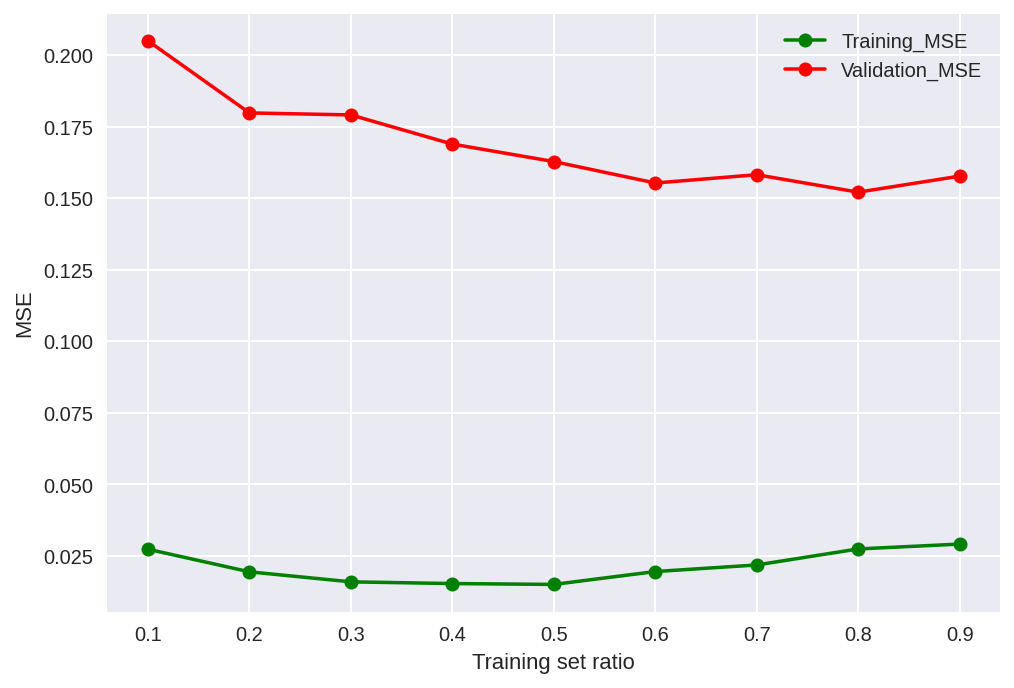

In [88]:
train_sizes = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
Training_MSE = np.array([])
Validation_MSE = np.array([])

for s in range(len(train_sizes)):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_sizes[s], random_state=12)
  xgb_reg_start = time.time()

  #use default hyperparams
  xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror',colsample_bytree = 0.2,learning_rate = 0.1,
                  max_depth = 10, alpha = 7, min_child_weight = 2, n_estimators = 500)

  xgb_reg.fit(X_train, y_train)

  training_preds_xgb_reg = xgb_reg.predict(X_train)
  val_preds_xgb_reg = xgb_reg.predict(X_test)

  Training_MSE = np.append(Training_MSE, round(mean_squared_error(y_train, training_preds_xgb_reg),4))
  Validation_MSE = np.append(Validation_MSE,round(mean_squared_error(y_test, val_preds_xgb_reg),4))

#manually plot MSE
plt.plot(train_sizes, Training_MSE, '-ok', color='green',label="Training_MSE")
plt.plot(train_sizes, Validation_MSE, '-ok', color='red', label = "Validation_MSE")
plt.xlabel("Training set ratio")
plt.ylabel("MSE")
plt.legend()